# Evaluating Metagenomic Prediciton of the Metaproteome in a 4.5 Year Study of a Crohn's Patient

Date: 8/3/2018 <br>
Author: Robert Mills <br>
Environment: Python3

Project Abstract: <br><br>
Although genetic approaches are the standard in microbiome analysis, proteome-level information is largely absent. This discrepancy warrants a better understanding of the relationship between genetic copy number and protein abundance, as this is crucial information for inferring protein level changes from metagenomic data. As it is unknown how these systems are altered during disease states, we leverage a six-year fecal time series of a single patient with Colonic Crohn’s disease. Utilizing Tandem Mass Tag (TMT) multiplexed proteomics and shotgun metagenomic sequencing, we quantify over 29,000 protein groups and 110,000 genes and compare them to the clinical diagnostics of serum C-reactive protein, fecal calprotectin, and lysozyme. Results indicate that many broad scale observations were consistent between data types, including fluctuations in Gene Ontology (GO) terms related to IBD severity such as formate oxidation and nitrate utilization. By applying linear regression we determined genes and proteins related to clinical metrics, and observed many conserved taxonomic differences relevant to Crohn’s disease such as negative correlation of Faecalibacterium and positive correlation of Escherichia to fecal calprotectin. Despite consistent genera associations, the specific genes correlated with these metrics were almost entirely different between the two data types. Unique protein-level functional changes were observed relating to clinical markers, and the metaproteome revealed unique functional relationships not seen in the metagenome. These relationships include a previously established connection between urease enzymes, amino acid metabolism and local inflammation. This proof-of-concept metagenomic-metaproteomic approach prompts further investigation of the metaproteome and its relations to the metagenome in larger cohorts.

### Load all Dependencies 

In [1]:
import math
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import seaborn as sns
from scipy.stats import linregress
import statsmodels
from statsmodels.stats.multitest import fdrcorrection
from matplotlib_venn import venn2
from biom import load_table
from skbio import TreeNode
from patsy import dmatrix
from dsfdr import dsfdr
from dsfdr import simulation
from dsfdr import statistics
from dsfdr import transform

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Makes figures with white background
sns.set_style("white")
%matplotlib inline

### User Defined Functions

In [3]:
ttests=[]
def ttest(df, df_sub1, df_sub2):
    """
    This function takes two subsetted dataframes where
    protein ID's are along the index and the samples
    you are testing are in the columns, and performs a
    ttest to determine whether each protein in the 
    subsets are at different levels. This function
    returns the original dataframe with a new column 
    for the p-value associated with the t-test. 
    equal_var can be set to True or false depending 
    on whether youneed to perform welches correction 
    on the data.
    
    parameters
    ----------
    df: pd.DataFrame
    df_sub1: pd.DataFrame
    df_sub2: pd.DataFrame
    
    returns
    -------
    dataframe with p-values
    
    """
    from scipy.stats import ttest_ind
    df_sub1 = df_sub1.transpose() # Transposition is  required
    df_sub2 = df_sub2.transpose()
    ttests = ttest_ind(df_sub1,df_sub2,equal_var=False,
                       nan_policy='omit')
    ttests = ttests.pvalue.transpose() # Transpose the pvalues back to the original orientation.
    df['ttest_pvalue']=ttests
    return df

In [4]:
def fold(df, sub1, sub2, sub1name, sub2name):
    """
    Creates a new column in your dataframe (df) for fold change between
    two sample types (in separate dataframes sub1 and sub2).
    
    Parameters
    ----------
    df : pd.DataFrame
    sub1 : pd.DataFrame
    sub2 : pd.DataFrame
    sub1name : string
    sub2name : string
    
    Returns
    -------
    Newly formed column in your dataframe.
    """
    df['%s Mean' % (sub1name)]=sub1.mean(axis=1,skipna=True)
    df['%s Mean' % (sub2name)]=sub2.mean(axis=1,skipna=True)
    df['Fold Change(%s/%s)' % (sub1name, sub2name)]=df['%s Mean' % (sub1name)]/df['%s Mean' % (sub2name)]
    return df['Fold Change(%s/%s)' % (sub1name, sub2name)]

In [5]:
def piscore(df,sub1name,sub2name):
    """
    pi score is a function which combines outputs from ttest and fold change functions
    and multiplies them to help pick biologically relevant hits within your systems.
    
    Parameters
    ----------
    df : pd.DataFrame
    sub1name : string
    sub2name: string
    
    Returns
    -------
    Newly formed column in your dataframe
    
    
    """
    df['Log2(Fold Change)'] = np.log2(df['Fold Change(%s/%s)'% (sub1name,sub2name)])
    df['-Log(P-value)'] = -np.log10(df['ttest_pvalue'])
    df['%s/%s pi score' % (sub1name,sub2name)] = df['-Log(P-value)']*df['Log2(Fold Change)']
    return df['%s/%s pi score' % (sub1name,sub2name)]

In [6]:
def TwoCategoryMaster(dfmain,dfsub1,dfsub2,sub1name,sub2name):
    """
    This function combines previously created user-defined functions to streamline the data
    analysis.
    
    Parameters
    ----------
    dfmain : pd.DataFrame
    dfsub1 : pd.DataFrame
    dfsub2 : pd.DataFrame
    sub1name : string
    sub2name : string
    
    Returns
    -------
    Updated dataframe
    """
    ttest(dfmain,dfsub1,dfsub2)
    fold(dfmain,dfsub1,dfsub2,sub1name,sub2name)
    piscore(dfmain,sub1name,sub2name)
    return dfmain

In [7]:
def avgstd(df,colmean,colstd,col1,col2,col3):
    """
    Creates new columns in your dataframe calculating the average and the standard deviation of three replicates.
    NAs are skipped
    
    Parameters
    ----------
    df : Input dataframe (pd.Dataframe)
    colmean : Name for the mean column (string) 
    colstd : Name for the standard deviation column (string)
    col1 : Name of technical replicate column (string)
    col2 : Name of technical replicate column (string)
    col3 : Name of technical replicate column (string)
    
    Returns
    -------
    Newly formed columns in your dataframe
    """
    df[colmean] = df[[col1,col2,col3]].mean(axis=1, skipna=True)
    df[colstd] = df[[col1,col2,col3]].std(axis=1, skipna=True)
    return df[colmean], df[colstd]

In [8]:
def sumstd(df,colsum,colstd,col1,col2,col3):
    """
    Creates new columns in your dataframe calculating the average and the standard deviation of three replicates.
    NAs are skipped
    
    Parameters
    ----------
    df : Input dataframe (pd.Dataframe)
    colsum : Name for the summed column (string) 
    colstd : Name for the standard deviation column (string)
    col1 : Name of technical replicate column (string)
    col2 : Name of technical replicate column (string)
    col3 : Name of technical replicate column (string)
    
    Returns
    -------
    Newly formed columns in your dataframe
    """
    df[colsum] = df[[col1,col2,col3]].sum(axis=1, skipna=True)
    df[colstd] = df[[col1,col2,col3]].std(axis=1, skipna=True)
    return df[colsum], df[colstd]

In [9]:
def eggRatioCompare(df_sig,df2_sig,variable):
    """
    This function combines several lines of code to speed up comparative analyses between two data sets
    (UC Severity)
    
    Parameters
    ----------
    df_sig : pd.DataFrame
    df2_sig : pd.DataFrame
    variable : Name of variable you're comparing ratios of
    
    Returns
    -------
    2 Dataframes, one with raw counts and one with comparative ratios
    """
    #Split up protein metadata for MG and sum it at for the desired variable
    s = df_sig['Cross-reference (eggNOG)'].str.split(';').apply(pd.Series, 1).stack()
    s.index = s.index.droplevel(-1) # to line up with df's index
    s.name = 'Parsed_Categories'
    GO = df_sig.join(s)
    GO['Parsed_Categories'] = GO['Parsed_Categories'].str.strip()
    df_sig3 = GO.merge(COG_cats, left_on = 'Parsed_Categories', right_on = 'COG', how = 'left')
    df_sig3 = df_sig3.merge(Cat_key, left_on = 'eggNOG_Code', right_on = 'eggNOG Functional Assignment', how = 'left')
    df_sig3 = df_sig3.merge(COG, left_on = 'COG', right_on = 'COG', how = 'left')
    #Add an additional step specifically for the proteins mapping to multiple COG which are of the same Description...
    labels = ['Ref_ID','Parsed_Categories']
    df_sig3['Ref_eggNOG'] = df_sig3['Ref_ID']+" "+df_sig3['Description']
    df_sig3['Ref_eggNOG']
    #Drop to keep only 1 category/description per reference
    df_sig4 = df_sig3.drop_duplicates(subset = 'Ref_eggNOG', keep = 'first')
    df_sig = df_sig4
    
    #Split up protein metadata for MG and sum it at for the desired variable
    s = df2_sig['Cross-reference (eggNOG)'].str.split(';').apply(pd.Series, 1).stack()
    s.index = s.index.droplevel(-1) # to line up with df's index
    s.name = 'Parsed_Categories'
    GO = df2_sig.join(s)
    GO['Parsed_Categories'] = GO['Parsed_Categories'].str.strip()
    df2_sig3 = GO.merge(COG_cats, left_on = 'Parsed_Categories', right_on = 'COG', how = 'left')
    df2_sig3 = df2_sig3.merge(Cat_key, left_on = 'eggNOG_Code', right_on = 'eggNOG Functional Assignment', how = 'left')
    df2_sig3 = df2_sig3.merge(COG, left_on = 'COG', right_on = 'COG', how = 'left')
    #Add an additional step specifically for the proteins mapping to multiple COG which are of the same Description...
    labels = ['Ref_ID','Parsed_Categories']
    df2_sig3['Ref_eggNOG'] = df2_sig3['Ref_ID']+" "+df2_sig3['Description']
    df2_sig3['Ref_eggNOG']
    #Drop to keep only 1 category/description per reference
    df2_sig4 = df2_sig3.drop_duplicates(subset = 'Ref_eggNOG', keep = 'first')
    df2_sig = df2_sig4
    
    #Subset out the significant positive and negative correlations
    Cal_neg = df_sig[df_sig['rvalue'] < 0]
    Cal_pos = df_sig[df_sig['rvalue'] > 0]

    #Subset out the significant positive and negative correlations MG
    Cal_neg2 = df2_sig[df2_sig['rvalue'] < 0]
    Cal_pos2 = df2_sig[df2_sig['rvalue'] > 0]
    
    
    #pDB Use this code if you want to simply look at quantity of significant proteins
    Cal_neg['%s_Pos' % variable] = 0
    Cal_pos['%s_Pos' % variable] = 1
    Cal_neg['%s_Neg' % variable] = 1
    Cal_pos['%s_Neg' % variable] = 0

    #MG Use this code if you want to simply look at quantity of significant proteins
    Cal_neg2['%s_Pos2' % variable] = 0
    Cal_pos2['%s_Pos2' % variable] = 1
    Cal_neg2['%s_Neg2' % variable] = 1
    Cal_pos2['%s_Neg2' % variable] = 0
    
    df_sig = pd.concat([Cal_neg, Cal_pos])

    df_sig2 = pd.concat([Cal_neg2, Cal_pos2])
    
    #Sum by category

    #Use this for eggNOG category
    dfcategories = df_sig[['%s_Neg' % variable,'%s_Pos' % variable]].groupby(df_sig['Description']).agg(['sum'])
    #Use this for Genera
    #dfcategories = df_sig[['%s_Neg' % variable,'%s_Pos' % variable]].groupby(df_sig['Genus']).agg(['sum'])
    dfcategories.columns = dfcategories.columns.droplevel(1)

    #MG

    #Use this for eggNOG category
    dfcategories2 = df_sig2[['%s_Neg2' % variable,'%s_Pos2' % variable]].groupby(df_sig2['Description']).agg(['sum'])
    #Use this for Genera
    #dfcategories2 = df_sig2[['%s_Neg2' % variable,'%s_Pos2' % variable]].groupby(df_sig2['Genus']).agg(['sum'])
    dfcategories2.columns = dfcategories2.columns.droplevel(1)
    
    #Save the postive and negative correlations per genera or eggNOG category
    counts = dfcategories.merge(dfcategories2, left_index = True, right_index = True, how = 'left')

    #Add a Pseudocount of 1 so that the categories without anything are still shown
    dfcategories = counts.replace(0,1)
    
    
    #Find the ratios necessary for calculating the ratio of ratios
    dfcategories['%s_Percent_Neg' % variable] = \
    dfcategories['%s_Neg' % variable]/dfcategories['%s_Neg' % variable].sum()
    dfcategories['%s_Percent_Pos' % variable] = \
    dfcategories['%s_Pos' % variable]/dfcategories['%s_Pos' % variable].sum()

    #Find the ratios necessary for calculating the ratio of ratios
    dfcategories['%s_Percent_Neg2' % variable] = \
    dfcategories['%s_Neg2' % variable]/dfcategories['%s_Neg2' % variable].sum()
    dfcategories['%s_Percent_Pos2' % variable] = \
    dfcategories['%s_Pos2' % variable]/dfcategories['%s_Pos2' % variable].sum()
    
    dfcategories['%s_Ratio of Percentages (Pos/Neg)' % variable] = dfcategories['%s_Percent_Pos' % variable]/dfcategories['%s_Percent_Neg' % variable]
    dfcategories['%s_Ratio of Percentages (Pos/Neg)2' % variable] = dfcategories['%s_Percent_Pos2' % variable]/dfcategories['%s_Percent_Neg2' % variable]
    
    
    dfcategories['%s_Log(Pos/Neg)' % variable] = np.log10(dfcategories['%s_Ratio of Percentages (Pos/Neg)' % variable])
    dfcategories['%s_Log(Pos/Neg)2' % variable] = np.log10(dfcategories['%s_Ratio of Percentages (Pos/Neg)2' % variable])
    
    global Ratios
    global Counts
    Ratios = dfcategories
    Counts = counts
    return 'Comparative ratios save under dataframe named Ratios, raw counts saved under dataframe named Counts'

In [10]:
def eggRatioCompare(df_sig,df2_sig,variable):
    """
    This function combines several lines of code to speed up comparative analyses between two data sets
    
    Parameters
    ----------
    df_sig : pd.DataFrame
    df2_sig : pd.DataFrame
    variable : Name of variable you're comparing ratios of
    
    Returns
    -------
    2 Dataframes, one with raw counts and one with comparative ratios
    """
    #Split up protein metadata for MG and sum it at for the desired variable
    s = df_sig['Cross-reference (eggNOG)'].str.split(';').apply(pd.Series, 1).stack()
    s.index = s.index.droplevel(-1) # to line up with df's index
    s.name = 'Parsed_Categories'
    GO = df_sig.join(s)
    GO['Parsed_Categories'] = GO['Parsed_Categories'].str.strip()
    df_sig3 = GO.merge(COG_cats, left_on = 'Parsed_Categories', right_on = 'COG', how = 'left')
    df_sig3 = df_sig3.merge(Cat_key, left_on = 'eggNOG_Code', right_on = 'eggNOG Functional Assignment', how = 'left')
    df_sig3 = df_sig3.merge(COG, left_on = 'COG', right_on = 'COG', how = 'left')
    #Add an additional step specifically for the proteins mapping to multiple COG which are of the same Description...
    labels = ['Ref_ID','Parsed_Categories']
    df_sig3['Ref_eggNOG'] = df_sig3['Ref_ID']+" "+df_sig3['Description']
    df_sig3['Ref_eggNOG']
    #Drop to keep only 1 category/description per reference
    df_sig4 = df_sig3.drop_duplicates(subset = 'Ref_eggNOG', keep = 'first')
    df_sig = df_sig4
    
    #Split up protein metadata for MG and sum it at for the desired variable
    s = df2_sig['Cross-reference (eggNOG)'].str.split(';').apply(pd.Series, 1).stack()
    s.index = s.index.droplevel(-1) # to line up with df's index
    s.name = 'Parsed_Categories'
    GO = df2_sig.join(s)
    GO['Parsed_Categories'] = GO['Parsed_Categories'].str.strip()
    df2_sig3 = GO.merge(COG_cats, left_on = 'Parsed_Categories', right_on = 'COG', how = 'left')
    df2_sig3 = df2_sig3.merge(Cat_key, left_on = 'eggNOG_Code', right_on = 'eggNOG Functional Assignment', how = 'left')
    df2_sig3 = df2_sig3.merge(COG, left_on = 'COG', right_on = 'COG', how = 'left')
    #Add an additional step specifically for the proteins mapping to multiple COG which are of the same Description...
    labels = ['Ref_ID','Parsed_Categories']
    df2_sig3['Ref_eggNOG'] = df2_sig3['Ref_ID']+" "+df2_sig3['Description']
    df2_sig3['Ref_eggNOG']
    #Drop to keep only 1 category/description per reference
    df2_sig4 = df2_sig3.drop_duplicates(subset = 'Ref_eggNOG', keep = 'first')
    df2_sig = df2_sig4
    
    #Subset out the significant positive and negative correlations
    Cal_neg = df_sig[df_sig['rvalue'] < 0]
    Cal_pos = df_sig[df_sig['rvalue'] > 0]

    #Subset out the significant positive and negative correlations MG
    Cal_neg2 = df2_sig[df2_sig['rvalue'] < 0]
    Cal_pos2 = df2_sig[df2_sig['rvalue'] > 0]
    
    
    #pDB Use this code if you want to simply look at quantity of significant proteins
    Cal_neg['%s_Pos' % variable] = 0
    Cal_pos['%s_Pos' % variable] = 1
    Cal_neg['%s_Neg' % variable] = 1
    Cal_pos['%s_Neg' % variable] = 0

    #MG Use this code if you want to simply look at quantity of significant proteins
    Cal_neg2['%s_Pos2' % variable] = 0
    Cal_pos2['%s_Pos2' % variable] = 1
    Cal_neg2['%s_Neg2' % variable] = 1
    Cal_pos2['%s_Neg2' % variable] = 0
    
    df_sig = pd.concat([Cal_neg, Cal_pos])

    df_sig2 = pd.concat([Cal_neg2, Cal_pos2])
    
    #Sum by category

    #Use this for eggNOG category
    dfcategories = df_sig[['%s_Neg' % variable,'%s_Pos' % variable]].groupby(df_sig['Description']).agg(['sum'])
    #Use this for Genera
    #dfcategories = df_sig[['%s_Neg' % variable,'%s_Pos' % variable]].groupby(df_sig['Genus']).agg(['sum'])
    dfcategories.columns = dfcategories.columns.droplevel(1)

    #MG

    #Use this for eggNOG category
    dfcategories2 = df_sig2[['%s_Neg2' % variable,'%s_Pos2' % variable]].groupby(df_sig2['Description']).agg(['sum'])
    #Use this for Genera
    #dfcategories2 = df_sig2[['%s_Neg2' % variable,'%s_Pos2' % variable]].groupby(df_sig2['Genus']).agg(['sum'])
    dfcategories2.columns = dfcategories2.columns.droplevel(1)
    
    #Save the postive and negative correlations per genera or eggNOG category
    counts = dfcategories.merge(dfcategories2, left_index = True, right_index = True, how = 'left')

    #Add a Pseudocount of 1 so that the categories without anything are still shown
    dfcategories = counts.replace(0,1)
    
    
    #Find the ratios necessary for calculating the ratio of ratios
    dfcategories['%s_Percent_Neg' % variable] = \
    dfcategories['%s_Neg' % variable]/dfcategories['%s_Neg' % variable].sum()
    dfcategories['%s_Percent_Pos' % variable] = \
    dfcategories['%s_Pos' % variable]/dfcategories['%s_Pos' % variable].sum()

    #Find the ratios necessary for calculating the ratio of ratios
    dfcategories['%s_Percent_Neg2' % variable] = \
    dfcategories['%s_Neg2' % variable]/dfcategories['%s_Neg2' % variable].sum()
    dfcategories['%s_Percent_Pos2' % variable] = \
    dfcategories['%s_Pos2' % variable]/dfcategories['%s_Pos2' % variable].sum()
    
    dfcategories['%s_Ratio of Percentages (Pos/Neg)' % variable] = dfcategories['%s_Percent_Pos' % variable]/dfcategories['%s_Percent_Neg' % variable]
    dfcategories['%s_Ratio of Percentages (Pos/Neg)2' % variable] = dfcategories['%s_Percent_Pos2' % variable]/dfcategories['%s_Percent_Neg2' % variable]
    
    
    dfcategories['%s_Log(Pos/Neg)' % variable] = np.log10(dfcategories['%s_Ratio of Percentages (Pos/Neg)' % variable])
    dfcategories['%s_Log(Pos/Neg)2' % variable] = np.log10(dfcategories['%s_Ratio of Percentages (Pos/Neg)2' % variable])
    
    global Ratios
    global Counts
    Ratios = dfcategories
    Counts = counts
    return 'Comparative ratios save under dataframe named Ratios, raw counts saved under dataframe named Counts'

In [11]:
def TaxaRatioCompare(df_sig,df2_sig,Taxa,variable):
    """
    This function combines several lines of code to speed up comparative analyses between two data sets.
    Input the data frames you want to compare and the name of the taxonomic level under Taxa.
    
    Parameters
    ----------
    df_sig : pd.DataFrame
    df2_sig : pd.DataFrame
    Taxa, String
    variable : Name of variable you're comparing ratios of

    Returns
    -------
    Dataframe with comparative ratios
    Dataframe with counts
    """
    
    #Subset out the significant positive and negative correlations
    Cal_neg = df_sig[df_sig['rvalue'] < 0]
    Cal_pos = df_sig[df_sig['rvalue'] > 0]

    #Subset out the significant positive and negative correlations MG
    Cal_neg2 = df2_sig[df2_sig['rvalue'] < 0]
    Cal_pos2 = df2_sig[df2_sig['rvalue'] > 0]
    
    
    #pDB Use this code if you want to simply look at quantity of significant proteins
    Cal_neg['%s_Pos' % variable] = 0
    Cal_pos['%s_Pos' % variable] = 1
    Cal_neg['%s_Neg' % variable] = 1
    Cal_pos['%s_Neg' % variable] = 0

    #MG Use this code if you want to simply look at quantity of significant proteins
    Cal_neg2['%s_Pos2' % variable] = 0
    Cal_pos2['%s_Pos2' % variable] = 1
    Cal_neg2['%s_Neg2' % variable] = 1
    Cal_pos2['%s_Neg2' % variable] = 0
    
    df_sig = pd.concat([Cal_neg, Cal_pos])

    df_sig2 = pd.concat([Cal_neg2, Cal_pos2])
    
    #Sum by category

    #Use this for summing by taxonomy
    dfcategories = df_sig[['%s_Neg' % variable,'%s_Pos' % variable]].groupby(df_sig['%s' % Taxa]).agg(['sum'])
    dfcategories.columns = dfcategories.columns.droplevel(1)

    #Use this for summing by taxonomy
    dfcategories2 = df_sig2[['%s_Neg2' % variable,'%s_Pos2' % variable]].groupby(df_sig2['%s' % Taxa]).agg(['sum'])
    dfcategories2.columns = dfcategories2.columns.droplevel(1)
    
    #Save the postive and negative correlations per genera or eggNOG category
    counts = dfcategories.merge(dfcategories2, left_index = True, right_index = True, how = 'left')

    #Add a Pseudocount of 1 so that the categories without anything are still shown
    dfcategories = counts.replace(0,1)
    
    
    #Find the ratios necessary for calculating the ratio of ratios
    dfcategories['%s_Percent_Neg' % variable] = \
    dfcategories['%s_Neg' % variable]/dfcategories['%s_Neg' % variable].sum()
    dfcategories['%s_Percent_Pos' % variable] = \
    dfcategories['%s_Pos' % variable]/dfcategories['%s_Pos' % variable].sum()

    #Find the ratios necessary for calculating the ratio of ratios
    dfcategories['%s_Percent_Neg2' % variable] = \
    dfcategories['%s_Neg2' % variable]/dfcategories['%s_Neg2' % variable].sum()
    dfcategories['%s_Percent_Pos2' % variable] = \
    dfcategories['%s_Pos2' % variable]/dfcategories['%s_Pos2' % variable].sum()
    
    dfcategories['%s_Ratio of Percentages (Pos/Neg)' % variable] = dfcategories['%s_Percent_Pos' % variable]/dfcategories['%s_Percent_Neg' % variable]
    dfcategories['%s_Ratio of Percentages (Pos/Neg)2' % variable] = dfcategories['%s_Percent_Pos2' % variable]/dfcategories['%s_Percent_Neg2' % variable]
    
    
    dfcategories['%s_Log(Pos/Neg)' % variable] = np.log10(dfcategories['%s_Ratio of Percentages (Pos/Neg)' % variable])
    dfcategories['%s_Log(Pos/Neg)2' % variable] = np.log10(dfcategories['%s_Ratio of Percentages (Pos/Neg)2' % variable])
    
    global Ratios
    global Counts
    Ratios = dfcategories
    Counts = counts
    return 'Comparative ratios save under dataframe named Ratios, raw counts saved under datarame name Counts'

### Load data

In [12]:
#Read in metadata
meta = pd.read_csv('LS_Metadata.txt', sep = '\t', index_col = 'id')
protein_meta_IGC = pd.read_csv('./IGC_Approach/Protein_Metadata(wHuman).csv', index_col = 'datarest$ProteinID')
protein_meta = pd.read_csv('./Duplicate_Peptide_Filter/pDB_UniProtKB.txt', sep = '\t')
protein_taxa = pd.read_csv('../Shotgun/Taxa_annotations_expanded.csv')
MG_ann = pd.read_csv('../Shotgun/MG_UniprotKB_Annotations.txt', sep = '\t')

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [53]:
#?df.drop()
len(protein_taxa[protein_taxa['Genus'] != ' g__'])

949801

In [69]:
len(MG_ann)

73292

In [70]:
len(MG_ann['Cross-reference (eggNOG)'].dropna())

25410

In [65]:
protein_meta['Cross-reference (KO)'].dropna()
#len(protein_meta[protein_meta['Cross-reference (KO)'] != np.nan])
#len(protein_meta[protein_meta['Cross-reference (eggNOG)'] != np.nan])

5        K02867;
8        K00656;
9        K02536;
10       K02950;
17       K02563;
23       K01119;
25       K01703;
26       K01689;
32       K00975;
33       K00615;
34       K10117;
40       K10540;
42       K10541;
45       K02056;
49       K12661;
50       K02357;
62       K02876;
65       K03150;
69       K01866;
71       K00975;
73       K03522;
74       K03521;
76       K00074;
77       K02884;
81       K04043;
85       K00639;
89       K02864;
96       K02358;
98       K02355;
99       K00215;
          ...   
12867    K01254;
12868    K04077;
12869    K00162;
12870    K08009;
12871    K07604;
12872    K00079;
12873    K06259;
12874    K04345;
12875    K06825;
12876    K05855;
12877    K02997;
12878    K06274;
12879    K01540;
12880    K07838;
12881    K12886;
12882    K06068;
12883    K17277;
12884    K04883;
12885    K05767;
12887    K06581;
12888    K13236;
12889    K22182;
12890    K10133;
12891    K14621;
12892    K21068;
12893    K11539;
12895    K09499;
12898    K0953

In [41]:
#Annotate COG Categories
COG = pd.read_csv('../../Georgia State Collaboration/COG.description.csv')
COG.columns = ['COG', 'COG Protein Name']
COG_cats = pd.read_csv('../../Georgia State Collaboration/COG.funccat.csv')
COG_cats.columns = ['COG', 'eggNOG_Code']
Cat_key = pd.read_csv('../../Georgia State Collaboration/eggNOG_FunCats.csv')

In [76]:
#Read in data tables

#Metaproteome data table
df2 = pd.read_csv("./Duplicate_Peptide_Filter/pDB_CSVs/NormalizedCommonReps.txt", sep = '\t', index_col = 'datarest$ProteinID')
df = pd.read_csv("./Duplicate_Peptide_Filter/pDB_CSVs/NormalizedDataAll_uniref50.csv", index_col = 'datarest$ProteinID')
df_IGC = pd.read_csv("./Duplicate_Peptide_Filter/IGC_CSVs/NormalizedDataAll.txt", index_col='datarest$ProteinID', sep='\t')

#Metagenome data table
MG = pd.read_csv("../Shotgun/Salmon_CPMs_Uniprot_Alignment.csv")

In [15]:
#Remove host proteins from common reps for taxonomy PCoA
dfcommon = df2[df2.index.str.contains('k99_') == True]
dfcommon.to_csv('./Duplicate_Peptide_Filter/pDB_CSVs/NormalizedCommonReps_nohuman.csv')

### Supplemental - Quantity of genes and proteins present in dataset

In [77]:
#Create a list of the 24 samples
samples = ['LS3.23.14_2', 'LS5.22.16_3', 'LS12.7.14_3', 'LS4.3.12_3',
       'LS9.24.13_2', 'LS2.17.14_2', 'LS12.28.11_1', 'LS7.14.13_1',
       'LS9.24.13_1', 'LS12.28.11_2', 'LS5.22.16_2', 'LS7.14.13_2',
       'LS4.3.12_2', 'LS12.7.14_1', 'LS3.23.14_3', 'LS2.17.14_3', 'LS4.3.12_1',
       'LS7.14.13_3', 'LS2.17.14_1', 'LS12.28.11_3', 'LS3.23.14_1',
       'LS9.24.13_3', 'LS5.22.16_1', 'LS12.7.14_2']
#Display the number of samples present
len(samples)

24

<b>Total Protein Stats

In [17]:
#29372 proteins in total in pDB metaproteome
len(df)

29372

In [18]:
#Subset out the proteins shared in all of the samples
#15461 proteins shared by all samples in pDB metaproteome
df_samples = df[samples]
len(df_samples.dropna())

15461

In [19]:
#25012 proteins in total in IGC metaproteome
len(df_IGC)

25098

In [20]:
#16371 proteins shared by all samples in the IGC metaproteome
len(df_IGC.dropna())

16371

<b>Human Protein Stats

In [21]:
#pDB Human Proteins
#Prodigal annotates their ORFs with 'k99_', so checking those without that value results in the number of human proteins:
len(df[df.index.str.contains('k99_') == False])

933

In [22]:
#pDB Human Proteins shared by all samples
df_samples_shared = df_samples.dropna()
len(df_samples_shared[df_samples_shared.index.str.contains('k99_') == False])

423

In [23]:
#IGC Human Proteins
df_IGC = df_IGC.merge(protein_meta_IGC, left_index = True, right_index = True, how = 'left')


In [24]:
#Number of human proteins within IGC in total
df_IGC_human = df_IGC[df_IGC['Taxonomic Annotation(Phylum Level)'] == 'Homo sapiens (Human)']
len(df_IGC_human)

912

In [25]:
#Number of human proteins in IGC with genes in all samples
len(df_IGC_human[samples].dropna())

434

<b>Metagenomic Genes Stats

In [26]:
#Remove the genes with duplicate queryIDs
MG = MG.drop_duplicates(subset = 'queryID', keep = 'first')
len(MG)

119653

In [27]:
#Find the number of metagenomic genes that are shared by all 24 samples
len(MG.dropna())

5076

### Supplemental - Number of overlapping peptides found

In [81]:
#Load in the data tables for IGC and pDB with the specific peptides found
df_IGC_peptides = pd.read_csv('./Duplicate_Peptide_Filter/IGC_Duplicate_Removed.csv')
df_pDB_peptides = pd.read_csv('./Duplicate_Peptide_Filter/pDB_Duplicate_Removed.csv')

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [82]:
#Create a list of the annotated sequences for comparisons
seqs = df_pDB_peptides['Annotated Sequence']

In [83]:
#Remove the tags on the left and right of the tryptic peptide sequences
sequences = []
for i in seqs:
    head, sep, tail = i.partition('].')
    head, sep, tail = tail.partition('.[')
    sequences.append(head)

In [84]:
#Add the core sequences without the tags to a new column on your dataframe
df_pDB_peptides['sequences'] = sequences

In [85]:
#Preform the same operations on the IGC based data
seqs = df_IGC_peptides['Annotated Sequence']

In [86]:
#Remove the tags on the left and right of the tryptic peptide sequences
sequences = []
for i in seqs:
    head, sep, tail = i.partition('].')
    head, sep, tail = tail.partition('.[')
    sequences.append(head)

In [87]:
df_IGC_peptides['sequences'] = sequences

In [88]:
#Number of PSMs identified in pDB
pDB_peptides = df_pDB_peptides['sequences']
len(pDB_peptides)

503353

In [89]:
#Number of PSMs identified in IGC
IGC_peptides = df_IGC_peptides['sequences']
len(IGC_peptides)

687197

In [90]:
#Subset to only the unique peptides 
pDB_peptides = set(pDB_peptides.drop_duplicates())
len(pDB_peptides)

94204

In [91]:
#Subset to only the unique peptides 
IGC_peptides = set(IGC_peptides.drop_duplicates())
len(IGC_peptides)

101363

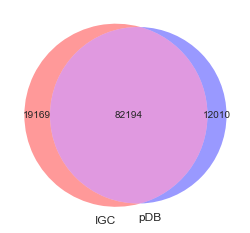

In [93]:
venn = venn2([IGC_peptides,pDB_peptides], ['IGC','pDB'], set_colors = ('red','blue'))
plt.savefig('./pdfs/Total_peptide_comparisons.pdf')

#### Sparsity in common ORFs


In [17]:
df

,Unnamed: 0,LS3.23.14_2,LS5.22.16_3,LS12.7.14_3,LS4.3.12_3,LS9.24.13_2,LS2.17.14_2,LS12.28.11_1,LS7.14.13_1,LS9.24.13_1,...,percIdentity,alnLength,mismatchCount,gapOpenCount,queryStart,queryEnd,subjectStart,subjectEnd,eVal,bitScore
datarest$ProteinID,,,,,,,,,,,,,,,,,,,,,
k99_1000046_1,110,61.067869,118.524388,68.681836,264.014067,171.733269,75.407012,110.085532,124.672957,144.374863,...,81.1,270.0,50.0,1.0,1.0,270.0,27.0,295.0,1.100000e-119,435.6
k99_1000192_1,111,132.240162,128.182893,106.207889,113.250556,68.767526,146.534332,115.097499,140.505533,54.954461,...,59.0,346.0,141.0,1.0,25.0,369.0,1.0,346.0,2.000000e-121,441.8
k99_100028_3,112,119.321443,118.902113,86.733568,115.623387,172.694078,110.145594,168.940314,69.936235,NaN,...,71.7,233.0,64.0,1.0,1.0,231.0,1.0,233.0,1.200000e-90,339.0
k99_100044_2,114,77.675573,80.351490,181.768393,39.106655,97.539981,98.553995,61.926157,195.475603,NaN,...,58.7,763.0,308.0,6.0,7.0,766.0,312.0,1070.0,1.300000e-271,941.8
k99_100044_3,115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,163.342699,...,99.8,548.0,1.0,0.0,1.0,548.0,1.0,548.0,0.000000e+00,1122.8
k99_1000497_2,116,131.543532,119.071840,241.041094,149.645728,82.554611,107.933536,155.855524,151.054945,111.326412,...,72.8,114.0,31.0,0.0,1.0,114.0,28.0,141.0,3.900000e-39,166.8
k99_1000512_1,117,135.625310,117.325487,118.977517,63.209572,173.799545,179.143850,130.884341,109.407693,NaN,...,70.7,92.0,27.0,0.0,21.0,112.0,124.0,215.0,2.500000e-30,137.5
k99_1000590_1,118,33.969219,21.335567,9.847595,455.562096,356.137409,29.749954,59.457066,12.214501,346.342804,...,60.3,179.0,62.0,3.0,1.0,178.0,97.0,267.0,5.500000e-56,223.4
k99_100074_1,119,92.117803,118.179735,126.085403,153.592976,175.982772,78.502470,123.120660,146.802967,136.341723,...,71.9,256.0,72.0,0.0,1.0,256.0,588.0,843.0,8.800000e-100,369.4


In [19]:
MG.columns

Index(['Unnamed: 0', 'LS12.28.11_1', 'LS12.28.11_2', 'LS12.28.11_3',
       'LS4.3.12_1', 'LS4.3.12_2', 'LS4.3.12_3', 'LS7.14.13_1', 'LS7.14.13_2',
       'LS7.14.13_3', 'LS9.24.13_1', 'LS9.24.13_2', 'LS9.24.13_3',
       'LS2.17.14_1', 'LS2.17.14_2', 'LS2.17.14_3', 'LS3.23.14_1',
       'LS3.23.14_2', 'LS3.23.14_3', 'LS12.7.14_1', 'LS12.7.14_2',
       'LS12.7.14_3', 'LS5.22.16_1', 'LS5.22.16_2', 'LS5.22.16_3', 'queryID',
       'subjectID', 'percIdentity', 'alnLength', 'mismatchCount',
       'gapOpenCount', 'queryStart', 'queryEnd', 'subjectStart', 'subjectEnd',
       'eVal', 'bitScore'],
      dtype='object')

In [20]:
MG.index = MG['queryID']
MG

,Unnamed: 0,LS12.28.11_1,LS12.28.11_2,LS12.28.11_3,LS4.3.12_1,LS4.3.12_2,LS4.3.12_3,LS7.14.13_1,LS7.14.13_2,LS7.14.13_3,...,percIdentity,alnLength,mismatchCount,gapOpenCount,queryStart,queryEnd,subjectStart,subjectEnd,eVal,bitScore
queryID,,,,,,,,,,,,,,,,,,,,,
k99_3_1,0,9.65858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,56.7,127,51,1,22,148,17,139,6.600000e-31,139.8
k99_7_1,1,1.96787,9.67657,NaN,2.166780,12.745700,20.199000,8.847020,13.038300,30.573800,...,57.5,301,128,0,2,302,28,328,3.800000e-102,377.5
k99_25_1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,87.1,171,22,0,2,172,10,180,1.500000e-79,301.6
k99_25_2,3,NaN,NaN,1.113890,NaN,NaN,NaN,NaN,NaN,0.880500,...,57.6,264,112,0,2,265,14,277,5.900000e-83,313.5
k99_29_1,4,4.50430,51.61890,26.036500,NaN,12.278600,4.470460,41.589500,20.542200,38.575800,...,99.2,126,1,0,1,126,16,141,1.900000e-63,247.7
k99_29_2,5,3.27367,11.53510,10.824600,NaN,7.550430,13.323200,10.580600,23.677400,41.651900,...,87.0,162,21,0,53,214,3,164,1.000000e-72,279.3
k99_31_1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79.4,107,22,0,5,111,156,262,5.500000e-46,189.5
k99_33_1,7,NaN,NaN,NaN,NaN,0.738950,NaN,NaN,NaN,NaN,...,55.2,348,155,1,1,348,122,468,2.200000e-101,375.2
k99_33_2,8,2.39771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.9,270,118,5,1,262,1,258,4.500000e-59,234.2


In [25]:
shared = list(df.index & MG.index)

In [28]:
len(MG.loc[shared].dropna())

539

In [29]:
len(df.loc[shared].dropna())

2061

### MP MG Dynamic Range Comparison

In [102]:
#Read in data tables

#Metaproteome data table
df = pd.read_csv("./Duplicate_Peptide_Filter/pDB_CSVs/NormalizedDataAll_uniref50.csv", index_col = 'datarest$ProteinID')
df_IGC = pd.read_csv("./Duplicate_Peptide_Filter/IGC_CSVs/NormalizedDataAll.txt", index_col='datarest$ProteinID', sep='\t')

#Metagenome data table
MG = pd.read_csv("../Shotgun/Salmon_CPMs_Uniprot_Alignment.csv")

In [103]:
#Remove the genes with duplicate queryIDs
MG = MG.drop_duplicates(subset = 'queryID', keep = 'first')

In [104]:
#First make a list of the dates you want to average and get the standard deviation for
dates = ['LS12.28.11','LS4.3.12','LS7.14.13','LS9.24.13','LS2.17.14','LS3.23.14','LS12.7.14','LS5.22.16']

In [105]:
#Generate averages and standard deviations for the technical replicates
#Averages skip NAs
for i in dates:
    avgstd(df,"%s" %(i), "%s_Std" %(i), "%s_1" % (i), "%s_2" % (i), "%s_3" % (i))

for i in dates:
    avgstd(MG,"%s" %(i), "%s_Std" %(i), "%s_1" % (i), "%s_2" % (i), "%s_3" % (i))

In [106]:
for i in dates:
    sumstd(MG,"%s" %(i), "%s_Std" %(i), "%s_1" % (i), "%s_2" % (i), "%s_3" % (i))

In [107]:
#Change the index name
MG.index = MG['queryID']

In [108]:
#Subset to only look at the averages
dfcategories2 = MG[dates]
dfcategories = df[dates]

In [109]:
#To determine dynamic ranges, we are using only the genes which have at least one measurement at each date.
#This is to have a more comparable method to the metaproteome, which has at least one value in every protein.

dfcategories2.replace(0,np.nan, inplace =True)
dfcategories2 = dfcategories2.dropna()

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/pandas/core/frame.py:3795: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


In [110]:
#Calculate the standard deviation of each protein and gene
dfcategories["Std"] = dfcategories[dates].std(axis = 1)
dfcategories2["Std"] = dfcategories2[dates].std(axis = 1)

#Find the maximum value
dfcategories['Max'] = dfcategories[dates].max(axis=1)
dfcategories2['Max'] = dfcategories2[dates].max(axis=1)

#Find the minimum value
dfcategories['Min'] = dfcategories[dates].min(axis=1)
dfcategories2['Min'] = dfcategories2[dates].min(axis=1)

#Determine the maxmimum/minimum for the dynamic range of each protein or gene
dfcategories["Max/Min"] = dfcategories['Max']/dfcategories['Min']
dfcategories2["Max/Min"] = dfcategories2['Max']/dfcategories2['Min']

#Determine the Max - Min
dfcategories["Max-Min"] = dfcategories['Max']-dfcategories['Min']
dfcategories2["Max-Min"] = dfcategories2['Max']-dfcategories2['Min']

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [111]:
#Remove NAs by selecting for postive values at or above 1
dfcategories = dfcategories[dfcategories['Max/Min'] > 0.9]
dfcategories2 = dfcategories2[dfcategories2['Max/Min'] > 0.9]

In [112]:
#Calculate the log(Max/Min) for display purposes
dfcategories['logMax/Min'] = np.log10(dfcategories['Max/Min'])
dfcategories2['logMax/Min'] = np.log10(dfcategories2['Max/Min'])

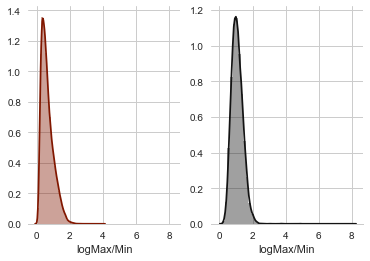

In [113]:
#Set style to have grids
sns.set_style("whitegrid")
# Set up the matplotlib figure
f, axes = plt.subplots(1,2, sharex=True)
sns.despine(left=True)
sns.distplot(dfcategories['logMax/Min'], ax=axes[0],color ='#811700')
sns.distplot(dfcategories2['logMax/Min'], ax=axes[1],color ='#131313')
plt.savefig('./pdfs/pDB_MG_DynamicRangeDistributionGenes_sns_sums.pdf')

In [114]:
#Find the statistics associated with each distribution
scipy.stats.describe(dfcategories2['logMax/Min'])

DescribeResult(nobs=26575, minmax=(0.16478650439307563, 8.112282887535862), mean=1.076421342992815, variance=0.12222314687321413, skewness=1.137016283363515, kurtosis=11.490920006259172)

In [115]:
#Find the statistics associated with each distribution
scipy.stats.describe(dfcategories['logMax/Min'])

DescribeResult(nobs=29371, minmax=(0.043770564365426125, 3.973564611253065), mean=0.6440634707643854, variance=0.13969616739852095, skewness=1.0808375604439084, kurtosis=1.2580591486258346)

In [116]:
#Calculate the log(Max/Min) for display purposes
dfcategories['logStd'] = np.log10(dfcategories['Std'])
dfcategories2['logStd'] = np.log10(dfcategories2['Std'])

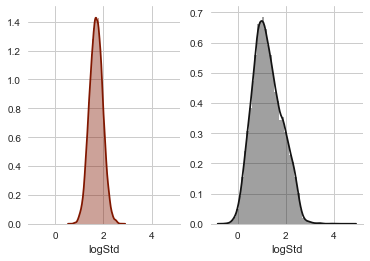

In [117]:
#Set style to have grids
sns.set_style("whitegrid")
# Set up the matplotlib figure
f, axes = plt.subplots(1,2, sharex=True)
sns.despine(left=True)
sns.distplot(dfcategories['logStd'], ax=axes[0],color ='#811700')
sns.distplot(dfcategories2['logStd'], ax=axes[1],color ='#131313')
plt.savefig('./pdfs/pDB_MG_STDDistributionGenes_sns_MGsums.pdf')

In [118]:
#Find the statistics associated with each distribution
scipy.stats.describe(dfcategories['logStd'])

DescribeResult(nobs=29371, minmax=(0.640663017785769, 2.7942868998072554), mean=1.6969388472416884, variance=0.0739635552099159, skewness=0.023958545786217707, kurtosis=-0.04743371368660432)

In [119]:
#Find the statistics associated with each distribution
scipy.stats.describe(dfcategories2['logStd'])

DescribeResult(nobs=26575, minmax=(-0.5883896524346184, 4.663814266827598), mean=1.2253753864761414, variance=0.3601602219054203, skewness=0.31676096891066974, kurtosis=-0.29296169341318024)

### Figure 2 MP MG Spearman Correlation Distribution


In [137]:
#Read in data tables

#Metaproteome data table
df = pd.read_csv("./Duplicate_Peptide_Filter/pDB_CSVs/NormalizedDataAll_uniref50.csv")
df_IGC = pd.read_csv("./Duplicate_Peptide_Filter/IGC_CSVs/NormalizedDataAll.txt", index_col='datarest$ProteinID', sep='\t')

#Metagenome data table
MG = pd.read_csv("../Shotgun/Salmon_CPMs_Uniprot_Alignment.csv")

#Remove the genes with duplicate queryIDs
MG = MG.drop_duplicates(subset = 'queryID', keep = 'first')

In [138]:
#Save the protein UniprotIDs for later
UniprotpDB = pd.concat([df['datarest$ProteinID'],df['subjectID']], axis = 1).drop_duplicates()
df.index = df['datarest$ProteinID']

In [133]:
#First make a list of the dates you want to average and get the standard deviation for
dates = ['LS12.28.11','LS4.3.12','LS7.14.13','LS9.24.13','LS2.17.14','LS3.23.14','LS12.7.14','LS5.22.16']

In [134]:
#Generate averages and standard deviations for the technical replicates
for i in dates:
    avgstd(df,"%s" %(i), "%s_Std" %(i), "%s_1" % (i), "%s_2" % (i), "%s_3" % (i))

for i in dates:
    avgstd(MG,"%s" %(i), "%s_Std" %(i), "%s_1" % (i), "%s_2" % (i), "%s_3" % (i))

In [135]:
for i in dates:
    sumstd(MG,"%s" %(i), "%s_Std" %(i), "%s_1" % (i), "%s_2" % (i), "%s_3" % (i))

In [136]:
#Change the index name
MG.index = MG['queryID']

In [137]:
#Subset to only look at the averages
dfcategories2 = MG[dates]
dfcategories = df[dates]

In [138]:
#To determine spearman correlations, we are replacing the missing values with 0s as the absence
#of a gene is possibly accounted for by the fact that it is not there.
dfcategories2 = dfcategories2.replace(np.nan, 0)

In [139]:
#Analyze only the genes which have protein level quanties
merge = dfcategories.merge(dfcategories2, left_index = True, right_index = True)

In [140]:
#Generate a list of IDS shared between the metagenome and metaproteome
shared = list(merge.index)

In [141]:
#Make a subsetted dataframe with only the ORFs shared between the two datasets
dfMP = dfcategories.loc[shared]
dfMG = dfcategories2.loc[shared]

In [142]:
#Create a transposed dataframe as a prerequisite for the next function
dfMP2 = dfMP.T
dfMG2 = dfMG.T

In [143]:
#Perform spearman correlations on each shared protein
corrs = []
for i in shared:
    corr = dfMP2['%s' % i].corr(dfMG2['%s' % i], method='spearman')
    corrs.append(corr)

In [144]:
#Generate a dataframe with all the spearman correlations
corrsdf = pd.DataFrame(
{'shared_genes' : shared,
 'Spearman_Corr' : corrs})

In [145]:
#Drop the genes which a spearman correlation could not be made due to lack of viable data in the metagenome
corrsdf = corrsdf.dropna()

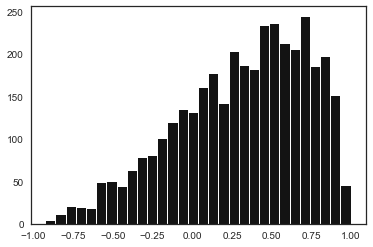

In [146]:
#Set style to have not have grids
sns.set_style("white")
plt.hist(corrsdf["Spearman_Corr"], color ='#131313', rwidth = 0.9, bins = 30)
plt.savefig('./pdfs/MPMG_Genes_SpearmanCorrelationDistributions_0forna_30bins_MGsums.pdf')

In [147]:
#Descriptive statistics on the distribution
scipy.stats.describe(corrsdf['Spearman_Corr'])

DescribeResult(nobs=3666, minmax=(-0.9221722216732094, 1.0), mean=0.3174244548936225, variance=0.16577758395246292, skewness=-0.5565896530653726, kurtosis=-0.41675527019044667)

### Figure 3A - Spearman Correlation Breakdown by eggNOG

<i>Continue from Figure 2E Code

In [148]:
#Determine the UniprotKBs associated with each prodigal ID
MG = pd.read_csv("../Shotgun/Salmon_CPMs_Uniprot_Alignment.csv")

In [149]:
#Retrieve prodigal alignments to the uniref_50
UniprotMG = pd.concat([MG['queryID'],MG['subjectID']], axis = 1).drop_duplicates()

In [150]:
#Read in metadata
meta = pd.read_csv('LS_Metadata.txt', sep = '\t', index_col = 'id')
protein_meta_IGC = pd.read_csv('./IGC_Approach/Protein_Metadata(wHuman).csv', index_col = 'datarest$ProteinID')
protein_meta = pd.read_csv('./Duplicate_Peptide_Filter/pDB_UniProtKB.txt', sep = '\t')
protein_taxa = pd.read_csv('../Shotgun/Taxa_annotations_expanded.csv')
MG_ann = pd.read_csv('../Shotgun/MG_UniprotKB_Annotations.txt', sep = '\t')
#For annotating with COG assignments and corresponding eggNOG
COG = pd.read_csv('../../Georgia State Collaboration/COG.description.csv')
COG.columns = ['COG', 'COG Protein Name']
COG_cats = pd.read_csv('../../Georgia State Collaboration/COG.funccat.csv')
COG_cats.columns = ['COG', 'eggNOG_Code']
Cat_key = pd.read_csv('../../Georgia State Collaboration/eggNOG_FunCats.csv')

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [151]:
#Retrieve prodigal alignments to the uniref_50
Uniprot = pd.concat([MG['queryID'],MG['subjectID']], axis = 1).drop_duplicates()

#Add annotation information on the shared dataframe
merge2 = merge.merge(Uniprot, left_index = True, right_on = "queryID", how = 'left')
merge2 = merge2.merge(protein_taxa, left_on = 'queryID', right_on = 'Ref_ID', how = 'left')
merge2 = merge2.merge(protein_meta, left_on = 'subjectID', right_on = 'Entry', how = 'left')
merge2 = merge2.merge(corrsdf, left_on = 'Ref_ID', right_on = 'shared_genes', how = 'left')

In [152]:
#Split up protein metadata for pDB if you want to add COG categories...
s = merge2['Cross-reference (eggNOG)'].str.split(';').apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1) # to line up with df's index
s.name = 'Parsed_Categories'
merge3 = merge2.join(s)
merge3['Parsed_Categories'] = merge3['Parsed_Categories'].str.strip()

In [153]:
#Add eggNOG annotations
merge3 = merge3.merge(COG_cats, left_on = "Parsed_Categories", right_on = 'COG', how = 'left')
merge3 = merge3.merge(Cat_key, left_on = 'eggNOG_Code', right_on = 'eggNOG Functional Assignment', how = 'left')
merge3 = merge3.merge(COG, left_on = 'COG', right_on = 'COG', how = 'left')

In [154]:
#Get a list of the eggNOG categories
cats = list(merge3['Description'].drop_duplicates())

In [155]:
#Generate statistics about each eggNOG category
medians = []
means = []
stds = []
for i in  cats:
    sub = merge3[merge3['Description'] == i]
    med = sub['Spearman_Corr'].median()
    mean = sub['Spearman_Corr'].mean()
    std = sub['Spearman_Corr'].std()
    medians.append(med)
    means.append(mean)
    stds.append(std)

In [156]:
#Melt the spearman correlations for use with seaborn visualization
id_vars = ['Description', 'COG']
value_vars = ['Spearman_Corr']
merge_melt = pd.melt(merge3, id_vars = id_vars, value_vars = value_vars)

In [157]:
#Generate dataframe with categories information
catsdf = pd.DataFrame(
{'eggNOG Category' : cats,
'Median' : medians,
'Mean' : means,
'Standard_Deviation' : stds})

In [172]:
catsdf = catsdf.sort_values(by = 'Median')

In [173]:
order = catsdf['eggNOG Category'].dropna()

12    Cell cycle control, cell division, chromosome ...
19                                        Cell motility
8                                      Function unknown
1                      Energy production and conversion
7       Translation, ribosomal structure and biogenesis
6                      General function prediction only
11                                        Transcription
5                     Coenzyme transport and metabolism
10                       Lipid transport and metabolism
3                   Amino acid transport and metabolism
9                   Nucleotide transport and metabolism
4                 Carbohydrate transport and metabolism
14                Replication, recombination and repair
13    Intracellular trafficking, secretion, and vesi...
18                       Signal transduction mechanisms
15    Posttranslational modification, protein turnov...
2                Cell wall/membrane/envelope biogenesis
17              Inorganic ion transport and meta

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


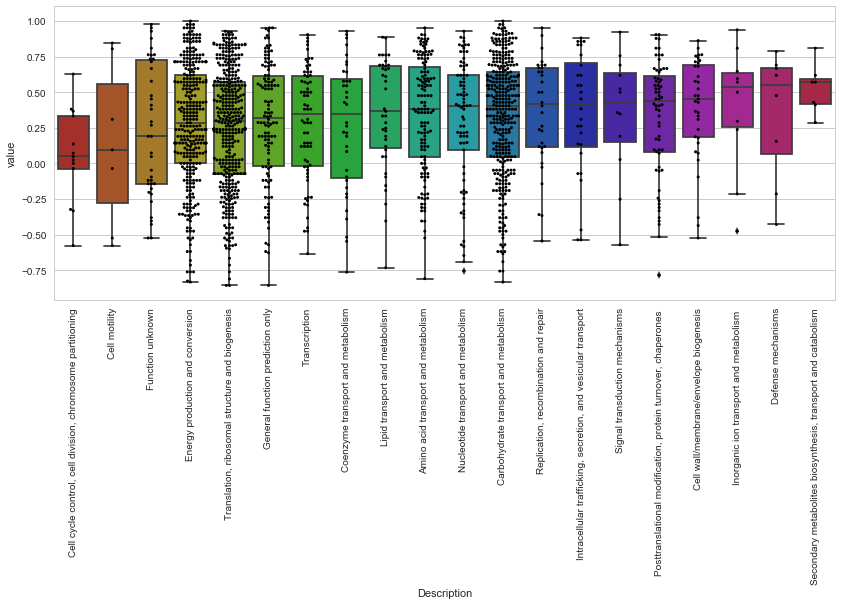

In [174]:
#Plot the spearman distributions in boxplots per category

#Set style to have grids
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize = (14,6))
#sns.violinplot(x = 'value', y = 'Description', inner = None, data = merge_melt,cut=0, palette = sns.hls_palette(20, l=.4, s=.8))
sns.swarmplot(x = 'Description', y = 'value', order = order, alpha = 1, data = merge_melt, color = 'black', size=3)
sns.boxplot(x = 'Description', y = 'value', order = order,data = merge_melt, palette = sns.hls_palette(20, l=.4, s=.8))
fig.autofmt_xdate(rotation = 90, ha = 'center')
plt.savefig('./Duplicate_Peptide_Filter/eggNOG_Spearman_Distributions_perGene_Boxes_horizontal_MGsums.pdf', bbox_inches = 'tight')

#### Generate Supplemental Table (Statistics on Figure 3a)

In [175]:
#Generate a dataframe from the counts of each category
from collections import Counter
counts = Counter(merge_melt['Description'])
countsdf = pd.DataFrame.from_dict(counts, orient = 'index')

In [176]:
catsdf = catsdf.merge(countsdf, left_on = 'eggNOG Category', right_index = True, how = 'left')

In [177]:
catsdf.rename(index = str, columns={0:"Number of Observations"})

,Mean,Median,Standard_Deviation,eggNOG Category,Number of Observations
12,0.055269,0.048795,0.331796,"Cell cycle control, cell division, chromosome ...",13
19,0.131198,0.095238,0.571056,Cell motility,7
8,0.233369,0.190476,0.471471,Function unknown,39
1,0.278751,0.285714,0.419777,Energy production and conversion,312
7,0.250296,0.296088,0.413681,"Translation, ribosomal structure and biogenesis",382
6,0.292468,0.318425,0.418561,General function prediction only,114
11,0.282257,0.345238,0.391005,Transcription,68
5,0.265905,0.350236,0.456734,Coenzyme transport and metabolism,37
10,0.352770,0.365963,0.391823,Lipid transport and metabolism,39
3,0.345145,0.380952,0.396415,Amino acid transport and metabolism,131


In [178]:
catsdf.to_csv('./Supplemental_table_eggNOG_Spearman_Statistics_MGSums.csv')

### GO categories Spearman correlations and statistics

In [252]:
#Read in data tables

#Metaproteome data table
df = pd.read_csv("./Duplicate_Peptide_Filter/pDB_CSVs/NormalizedDataAll_uniref50.csv", index_col = 'datarest$ProteinID')
df_IGC = pd.read_csv("./Duplicate_Peptide_Filter/IGC_CSVs/NormalizedDataAll.txt", index_col='datarest$ProteinID', sep='\t')

#Metagenome data table
MG = pd.read_csv("../Shotgun/Salmon_CPMs_Uniprot_Alignment.csv")
#Remove the genes with duplicate queryIDs
MG = MG.drop_duplicates(subset = 'queryID', keep = 'first')

#Filter out human proteins to specifically look into the microbiome

df = df[df.index.str.contains('k99_') != False]

#Read in metadata
meta = pd.read_csv('LS_Metadata.txt', sep = '\t', index_col = 'id')
protein_meta_IGC = pd.read_csv('./IGC_Approach/Protein_Metadata(wHuman).csv', index_col = 'datarest$ProteinID')
protein_meta = pd.read_csv('./Duplicate_Peptide_Filter/pDB_UniProtKB.txt', sep = '\t')
protein_taxa = pd.read_csv('../Shotgun/Taxa_annotations_expanded.csv')
MG_ann = pd.read_csv('../Shotgun/MG_UniprotKB_Annotations.txt', sep = '\t')

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [253]:
samples = ['LS3.23.14_2', 'LS5.22.16_3', 'LS12.7.14_3', 'LS4.3.12_3',
       'LS9.24.13_2', 'LS2.17.14_2', 'LS12.28.11_1', 'LS7.14.13_1',
       'LS9.24.13_1', 'LS12.28.11_2', 'LS5.22.16_2', 'LS7.14.13_2',
       'LS4.3.12_2', 'LS12.7.14_1', 'LS3.23.14_3', 'LS2.17.14_3', 'LS4.3.12_1',
       'LS7.14.13_3', 'LS2.17.14_1', 'LS12.28.11_3', 'LS3.23.14_1',
       'LS9.24.13_3', 'LS5.22.16_1', 'LS12.7.14_2']
len(samples)

24

In [254]:
MG = MG.merge(MG_ann, left_on = 'subjectID', right_on = 'Entry', how = 'left')
df = df.merge(protein_meta, left_on = 'subjectID', right_on = 'Entry', how = 'left')

In [255]:
#Split up dataframe by metadata for MG if you want to add GO categories...
s = MG['Gene ontology (GO)'].str.split(';').apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1) # to line up with df's index
s.name = 'Parsed_Categories'
GO = MG.join(s)
GO['Parsed_Categories'] = GO['Parsed_Categories'].str.strip()

#Group the data by GO terms
dfcategories2 = GO[samples].groupby([GO['Parsed_Categories']]).agg(['sum'])
dfcategories2.columns = dfcategories2.columns.droplevel(1)

#Find the number of genes contributing to the category
dfcategories2_count = GO[samples].groupby([GO['Parsed_Categories']]).count()

In [256]:
#Split up dataframe by protein metadata for pDB if you want to add GO categories...
s = df['Gene ontology (GO)'].str.split(';').apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1) # to line up with df's index
s.name = 'Parsed_Categories'
GO = df.join(s)
GO['Parsed_Categories'] = GO['Parsed_Categories'].str.strip()

#Group the data by GO terms
dfcategories = GO[samples].groupby([GO['Parsed_Categories']]).agg(['sum'])
dfcategories.columns = dfcategories.columns.droplevel(1)

#Find the number of genes contributing to the category
dfcategories_count = GO[samples].groupby([GO['Parsed_Categories']]).count()

In [257]:
#Plotting certain GO categories which had interesting trends

#Selection of categories of interest
MP_Formox = dfcategories.loc['formate oxidation [GO:0015944]']
MG_Formox = dfcategories2.loc['formate oxidation [GO:0015944]']
MP_Formdehydrog = dfcategories.loc['formate dehydrogenase (NAD+) activity [GO:0008863]']
MG_Formdehydrog = dfcategories2.loc['formate dehydrogenase (NAD+) activity [GO:0008863]']

In [258]:
MP_PolyCat = dfcategories.loc['polysaccharide catabolic process [GO:0000272]']
MG_PolyCat = dfcategories2.loc['polysaccharide catabolic process [GO:0000272]']
MG_Carbmeta = dfcategories2.loc['carbohydrate derivative metabolic process [GO:1901135]']
MP_Carbmeta = dfcategories.loc['carbohydrate derivative metabolic process [GO:1901135]']
MG_PolyTrans = dfcategories2.loc['polysaccharide transport [GO:0015774]']
MP_PolyTrans = dfcategories.loc['polysaccharide transport [GO:0015774]']
MG_CarbTrans = dfcategories2.loc['carbohydrate transport [GO:0008643]']
MP_CarbTrans = dfcategories.loc['carbohydrate transport [GO:0008643]']

In [259]:
MP_NitAss = dfcategories.loc['nitrate assimilation [GO:0042128]']
MG_NitAss = dfcategories2.loc['nitrate assimilation [GO:0042128]']
MG_NitRed = dfcategories2.loc['nitrate reductase activity [GO:0008940]']
MP_NitRed = dfcategories.loc['nitrate reductase activity [GO:0008940]']
MG_Anaer = dfcategories2.loc['anaerobic respiration [GO:0009061]']
MP_Anaer = dfcategories.loc['anaerobic respiration [GO:0009061]']
MG_Nit = dfcategories2.loc['nitrogen compound metabolic process [GO:0006807]']
MP_Nit = dfcategories.loc['nitrogen compound metabolic process [GO:0006807]']

In [260]:
MP_IronHom = dfcategories.loc['iron ion homeostasis [GO:0055072]']
MG_IronHom = dfcategories2.loc['iron ion homeostasis [GO:0055072]']
MG_IronBind = dfcategories2.loc['iron ion binding [GO:0005506]']
MP_IronBind = dfcategories.loc['iron ion binding [GO:0005506]']
MG_Cluster = dfcategories2.loc['2 iron, 2 sulfur cluster binding [GO:0051537]']
MP_Cluster = dfcategories.loc['2 iron, 2 sulfur cluster binding [GO:0051537]']

generate lists for visualization

MP_GO_List = [#MP_PolyCat,
    MP_Carbmeta,
    #MP_PolyTrans,
    MP_CarbTrans,
]
MG_GO_List = [#MG_PolyCat, 
    MG_Carbmeta,
    #MG_PolyTrans,
   MG_CarbTrans,
]
MP_GOs = pd.concat(MP_GO_List, axis = 1)
MG_GOs = pd.concat(MG_GO_List, axis = 1)
valueids = list(MG_GOs.columns)

MP_GO_List = [MP_WallMod,
    MP_Wall,
    #MP_Porins,
             # MP_Surface,
    #MP_OMP
]
MG_GO_List = [MG_WallMod, 
    MG_Wall,
    #MG_Porins,
              #MG_Surface,
    #MG_OMP
]
MP_GOs = pd.concat(MP_GO_List, axis = 1)
MG_GOs = pd.concat(MG_GO_List, axis = 1)
valueids = list(MG_GOs.columns)

MP_GO_List = [MP_Formox, MP_Formdehydrog]
MG_GO_List = [MG_Formox, MG_Formdehydrog]
MP_GOs = pd.concat(MP_GO_List, axis = 1)
MG_GOs = pd.concat(MG_GO_List, axis = 1)

MP_GO_List = [
    MP_IronHom,
    MP_IronBind,
    MP_Cluster,
]
MG_GO_List =  [MG_IronHom,
    MG_IronBind,
    MG_Cluster,
]
MP_GOs = pd.concat(MP_GO_List, axis = 1)
MG_GOs = pd.concat(MG_GO_List, axis = 1)
valueids = list(MG_GOs.columns)

In [261]:
MP_GO_List = [MP_NitAss,
    MP_NitRed,
    MP_Anaer,
    #MP_Nit,
]
MG_GO_List =  [MG_NitAss,
    MG_NitRed,
    MG_Anaer,
    #MG_Nit,
]
MP_GOs = pd.concat(MP_GO_List, axis = 1)
MG_GOs = pd.concat(MG_GO_List, axis = 1)
valueids = list(MG_GOs.columns)

In [262]:
MP_GOs['Date'] = list(MP_GOs.index.str[:-2])
MG_GOs['Date'] = list(MG_GOs.index.str[:-2])
d = {'Dates' : ['LS12.28.11','LS4.3.12','LS7.14.13','LS9.24.13','LS2.17.14','LS3.23.14','LS12.7.14', 'LS5.22.16'],
    'Time' : ["0","1","2","3","4","5","6","7"]}
order = pd.DataFrame(data = d)
MP_GOs = MP_GOs.reset_index().merge(order, left_on = 'Date', right_on = 'Dates', how = 'outer')
MG_GOs = MG_GOs.reset_index().merge(order, left_on = 'Date', right_on = 'Dates', how = 'outer')
MP_GOs['index'] = MP_GOs['index'].str[-1]
MG_GOs['index'] = MG_GOs['index'].str[-1]
ids = ['Date','Time','index']
MP_GOs_melt = pd.melt(MP_GOs, id_vars =ids, value_vars = valueids)
MG_GOs_melt = pd.melt(MG_GOs, id_vars =ids, value_vars = valueids)

#Either use or don't use log scale depending on visualization preferences
MP_GOs_melt['value'] = MP_GOs_melt['value'].astype('float')
MP_GOs_melt['value'] = np.log10(MP_GOs_melt['value'])
MG_GOs_melt['value'] = MG_GOs_melt['value'].astype('float')
MG_GOs_melt['value'] = np.log10(MG_GOs_melt['value'])

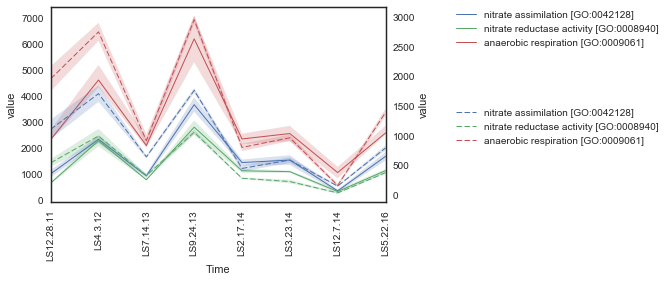

In [263]:
#Plot

#Repeat with other categories that are in markdown for other panels
#Set style to not have grids
sns.set_style("white")

fig, ax = plt.subplots()
ax = sns.tsplot(time="Time", value = 'value',ci = [50], unit = 'index', condition = "variable", data=MP_GOs_melt, linewidth = 1)
plt.legend(bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)
ax.set_xticklabels(dates)
ax2 = ax.twinx()
ax2 = sns.tsplot(time="Time", value = 'value',ci =[50], unit = 'index', condition = "variable", data=MG_GOs_melt, linewidth = 1, linestyle = "--")
plt.legend(bbox_to_anchor=(1.2, 0.5), loc=2, borderaxespad=0.)
fig.autofmt_xdate(rotation = 90, ha = 'center')
#plt.savefig("./Duplicate_Peptide_Filter/MGMP_Anaerobic_Respiration_tsplot.pdf",bbox_inches='tight')

#### Generate Supplemental Table (Statistics on GO Spearman Correlations, max/mins etc)

In [264]:
#First make a list of the dates you want to average and get the standard deviation for
dates = ['LS12.28.11','LS4.3.12','LS7.14.13','LS9.24.13','LS2.17.14','LS3.23.14','LS12.7.14','LS5.22.16']

In [265]:
#Find the average and standard deviation of each of the samples
for i in dates:
    avgstd(dfcategories,"%s" %(i), "%s_Std" %(i), "%s_1" % (i), "%s_2" % (i), "%s_3" % (i))

for i in dates:
    avgstd(dfcategories2,"%s" %(i), "%s_Std" %(i), "%s_1" % (i), "%s_2" % (i), "%s_3" % (i))

In [266]:
for i in dates:
    sumstd(dfcategories2,"%s" %(i), "%s_Std" %(i), "%s_1" % (i), "%s_2" % (i), "%s_3" % (i))

In [267]:
#Save dfcategories without the dropped 0s for later
MG_GO = dfcategories2

#Replace 0s with 1s for pseudocounts in the MG for max/min comparisons

dfcategories2.replace(0,np.nan,inplace=True)
dfcategories2 = dfcategories2.dropna()

In [268]:
#Calculate the standard deviation of each protein and gene
dfcategories["Std"] = dfcategories[dates].std(axis = 1)
dfcategories2["Std"] = dfcategories2[dates].std(axis = 1)

#Calculate the log(Std) for display purposes
dfcategories['logStd'] = np.log10(dfcategories['Std'])
dfcategories2['logStd'] = np.log10(dfcategories2['Std'])

#Find the maximum value
dfcategories['Max'] = dfcategories[dates].max(axis=1)
dfcategories2['Max'] = dfcategories2[dates].max(axis=1)

#Find the minimum value
dfcategories['Min'] = dfcategories[dates].min(axis=1)
dfcategories2['Min'] = dfcategories2[dates].min(axis=1)

#Determine the maxmimum/minimum for the dynamic range of each protein or gene
dfcategories["Max/Min"] = dfcategories['Max']/dfcategories['Min']
dfcategories2["Max/Min"] = dfcategories2['Max']/dfcategories2['Min']

#Calculate the log(Max/Min) for display purposes
dfcategories['logMax/Min'] = np.log10(dfcategories['Max/Min'])
dfcategories2['logMax/Min'] = np.log10(dfcategories2['Max/Min'])

#Determine the Max - Min
dfcategories["Max-Min"] = dfcategories['Max']-dfcategories['Min']
dfcategories2["Max-Min"] = dfcategories2['Max']-dfcategories2['Min']

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

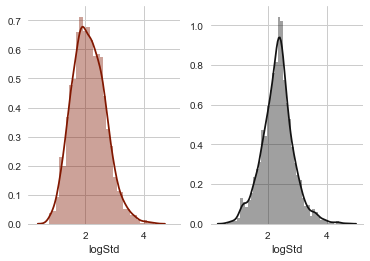

In [269]:
#Set style to have grids
sns.set_style("whitegrid")
# Set up the matplotlib figure
f, axes = plt.subplots(1,2, sharex=True)
sns.despine(left=True)
sns.distplot(dfcategories['logStd'], ax=axes[0],color ='#811700')
sns.distplot(dfcategories2['logStd'], ax=axes[1],color ='#131313')
plt.savefig('./pdfs/pDB_MG_STDDistributionGOs_sns_MGsums.pdf')

In [270]:
#Summary Statistics
scipy.stats.describe(dfcategories['logStd'])

DescribeResult(nobs=2279, minmax=(0.7523496827350414, 4.340113456392282), mean=2.114313314168678, variance=0.31133219509367394, skewness=0.3542223285517365, kurtosis=0.09783252540955134)

In [271]:
#Summary Statistics
scipy.stats.describe(dfcategories2['logMax/Min'])

DescribeResult(nobs=2235, minmax=(0.05114549041472617, 2.358323924177333), mean=0.6786193644061969, variance=0.1663099534828371, skewness=0.7696368291788727, kurtosis=-0.15112743344141233)

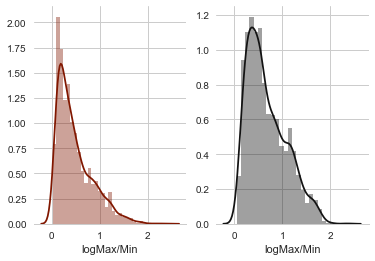

In [272]:
#Set style to have grids
sns.set_style("whitegrid")
# Set up the matplotlib figure
f, axes = plt.subplots(1,2, sharex=True)
sns.despine(left=True)
sns.distplot(dfcategories['logMax/Min'], ax=axes[0],color ='#811700')
sns.distplot(dfcategories2['logMax/Min'], ax=axes[1],color ='#131313')
plt.savefig('./pdfs/pDB_MG_MaxMinDistributionGOs_sns_MGsums.pdf')

In [273]:
#Summary Statistics
scipy.stats.describe(dfcategories['logMax/Min'])

DescribeResult(nobs=2279, minmax=(0.026130158277128133, 2.4129667703752293), mean=0.48476020989441043, variance=0.13751591724094892, skewness=1.2335044204001009, kurtosis=1.2869291225343344)

In [274]:
#Summary Statistics
scipy.stats.describe(dfcategories2['logMax/Min'])

DescribeResult(nobs=2235, minmax=(0.05114549041472617, 2.358323924177333), mean=0.6786193644061969, variance=0.1663099534828371, skewness=0.7696368291788727, kurtosis=-0.15112743344141233)

In [275]:
#Only work with the averages of each of the dates
dfMP = dfcategories[dates]
dfMG = MG_GO[dates]
dfMP = dfMP.T
dfMG = dfMG.T

In [276]:
#Find overlapping GO categories in the metagenome and metaproteome
merge = dfcategories.merge(MG_GO, left_index = True, right_index = True)

In [277]:
MP_GOs = list(merge.index)

In [278]:
corrs = []
for i in MP_GOs:
    corr = dfMP['%s' % i].corr(dfMG['%s' % i], method = 'spearman')
    corrs.append(corr)

In [279]:
corrsdf = pd.DataFrame(
{'GO' : MP_GOs,
 'Spearman_Corr' : corrs})
corrsdf.index = corrsdf['GO']

In [281]:
dfcategories2_count['Genes_Counted'] = dfcategories2_count.sum(axis = 1)
dfcategories_count['Proteins_Counted'] = dfcategories_count.sum(axis = 1)
Spearman_table = pd.concat([dfcategories_count['Proteins_Counted'],dfcategories2_count['Genes_Counted'], corrsdf['Spearman_Corr']], axis = 1)

In [284]:
#Save the tables as supplemental files
Spearman_table.dropna().to_csv('./GO_Spearman_Correlations_noNaN.csv')
Spearman_table.to_csv('./GO_Spearman_Correlations.csv')

In [285]:
merge2 = Spearman_table.merge(merge, left_index = True, right_index = True)

,Proteins_Counted,Genes_Counted,Spearman_Corr,LS3.23.14_2_x,LS5.22.16_3_x,LS12.7.14_3_x,LS4.3.12_3_x,LS9.24.13_2_x,LS2.17.14_2_x,LS12.28.11_1_x,...,LS9.24.13_y,LS9.24.13_Std_y,LS2.17.14_y,LS2.17.14_Std_y,LS3.23.14_y,LS3.23.14_Std_y,LS12.7.14_y,LS12.7.14_Std_y,LS5.22.16_y,LS5.22.16_Std_y
'de novo' AMP biosynthetic process [GO:0044208],2208.0,1248.0,0.285714,11157.679397,10586.584745,10945.756183,10740.125337,10771.765118,9521.944190,9988.154424,...,1683.203502,64.317396,1059.044102,53.504013,1145.323277,38.108997,854.424911,18.424851,1062.797248,43.475628
'de novo' CTP biosynthetic process [GO:0044210],896.0,1101.0,-0.023810,4749.245339,4754.776480,4184.135978,5305.001462,6008.081178,5042.303662,4659.588321,...,1616.042148,25.067029,1934.221896,31.287361,1775.561728,73.347030,2257.555498,69.710112,1924.963908,98.692466
'de novo' GDP-L-fucose biosynthetic process [GO:0042351],24.0,176.0,0.690476,96.993729,119.921560,92.403908,150.354444,107.231622,151.056742,131.779363,...,60.920107,2.201260,364.066329,7.488402,396.705071,52.944954,186.240790,7.098646,545.937977,36.674845
'de novo' IMP biosynthetic process [GO:0006189],4800.0,3888.0,0.619048,24704.260056,26278.336662,23687.816869,27826.505974,24112.356803,25629.417178,26155.678053,...,7062.597983,71.939311,5783.525346,487.383223,5696.658624,339.144194,4316.231479,191.594462,6470.689033,376.195580
'de novo' L-methionine biosynthetic process [GO:0071266],24.0,131.0,0.500000,486.410060,289.808527,497.524442,209.522250,436.783670,505.335336,489.794967,...,445.040630,12.742194,515.800339,28.420336,504.636052,32.118971,206.219985,8.649825,244.589443,25.871551
'de novo' NAD biosynthetic process from aspartate [GO:0034628],8.0,66.0,0.642857,79.893911,156.539368,14.083116,118.681104,525.279690,47.399927,34.700325,...,1037.311000,42.140150,322.514690,31.869613,354.232397,10.302573,30.704780,8.969552,623.807410,87.346966
'de novo' UMP biosynthetic process [GO:0044205],4208.0,3872.0,0.500000,21847.863121,22245.519032,23146.680523,24576.042703,21783.134494,20596.302023,22061.652729,...,4808.229258,36.008215,5314.402785,341.025607,5800.762475,39.065239,5703.795865,232.129539,5528.399760,229.787923
'de novo' pyrimidine nucleobase biosynthetic process [GO:0006207],2240.0,1899.0,-0.285714,10804.928440,11421.155675,12357.303700,12347.029545,11158.460126,10212.268909,12019.901811,...,2625.227738,54.548461,3506.808337,161.857701,2863.210858,54.952661,3167.067914,130.125627,3113.409615,114.745527
(R)-2-hydroxyacid dehydrogenase activity [GO:0050578],56.0,19.0,0.119048,260.437446,262.216502,217.322913,497.820858,86.901201,345.440508,400.027770,...,5.281590,1.647515,1.723370,0.994988,13.559550,1.032534,4.429160,1.707679,8.387500,2.421888
(S)-2-(5-amino-1-(5-phospho-D-ribosyl)imidazole-4-carboxamido)succinate AMP-lyase (fumarate-forming) activity [GO:0070626],1008.0,594.0,0.333333,5292.740132,4967.716010,5315.144654,4956.548912,4766.612392,4301.321783,4566.711275,...,1304.751745,63.110003,465.009775,10.933503,596.745900,13.325546,379.249235,32.158405,593.259161,63.350508


In [286]:
merge2.to_csv('./GO_Supplemental_table_comparisons.csv')

#### Generate Supplemental Figure (GO Spearman Correlations)


In [4]:
#Drop the categories with not enough values to generate spearman correlations
df = Spearman_table.dropna()

NameError: name 'Spearman_table' is not defined

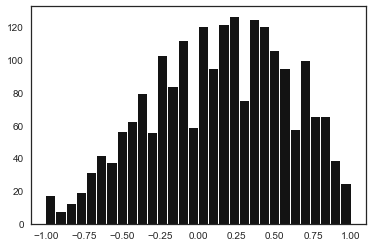

In [292]:
#Set style to have not have grids
sns.set_style("white")
plt.hist(df["Spearman_Corr"], color ='#131313', rwidth = 0.9, bins = 30)
plt.savefig('./pdfs/MPMG_GOs_SpearmanCorrelationDistributions_0forna_30bins_MGsums.pdf')

In [294]:
#Summary Statistics
scipy.stats.describe(df['Spearman_Corr'])

DescribeResult(nobs=2097, minmax=(-1.0, 1.0), mean=0.13614233485478122, variance=0.1980841523609897, skewness=-0.23948379857559335, kurtosis=-0.6653945142734075)

#### Supplemental statistics on KEGG Orthologous groups

In [94]:
#Read in data tables

#Metaproteome data table
df = pd.read_csv("./Duplicate_Peptide_Filter/pDB_CSVs/NormalizedDataAll_uniref50.csv", index_col = 'datarest$ProteinID')
df_IGC = pd.read_csv("./Duplicate_Peptide_Filter/IGC_CSVs/NormalizedDataAll.txt", index_col='datarest$ProteinID', sep='\t')

#Metagenome data table
MG = pd.read_csv("../Shotgun/Salmon_CPMs_Uniprot_Alignment.csv")
#Remove the genes with duplicate queryIDs
MG = MG.drop_duplicates(subset = 'queryID', keep = 'first')

#Filter out human proteins to specifically look into the microbiome

df = df[df.index.str.contains('k99_') != False]

#Read in metadata
meta = pd.read_csv('LS_Metadata.txt', sep = '\t', index_col = 'id')
protein_meta_IGC = pd.read_csv('./IGC_Approach/Protein_Metadata(wHuman).csv', index_col = 'datarest$ProteinID')
protein_meta = pd.read_csv('./Duplicate_Peptide_Filter/pDB_UniProtKB.txt', sep = '\t')
protein_taxa = pd.read_csv('../Shotgun/Taxa_annotations_expanded.csv')
MG_ann = pd.read_csv('../Shotgun/MG_UniprotKB_Annotations.txt', sep = '\t')

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### KO Overlap between Metaproteome databases

In [95]:
#IGC Human Proteins
df_IGC = df_IGC.merge(protein_meta_IGC, left_index = True, right_index = True, how = 'left')
df_pDB = df.merge(protein_meta, left_on = 'subjectID', right_on = 'Entry', how = 'left')

In [96]:
#Split up dataframe by protein metadata for pDB if you want to add GO categories...
s = df_pDB['Cross-reference (KO)'].str.split(';').apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1) # to line up with df's index
s.name = 'Parsed_Categories'
GO = df_pDB.join(s)
GO['Parsed_Categories'] = GO['Parsed_Categories'].str.strip()

In [97]:
#Split up dataframe by protein metadata for pDB if you want to add GO categories...
s = df_IGC['KO'].str.split(';').apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1) # to line up with df's index
s.name = 'Parsed_Categories'
IGC_GO = df_IGC.join(s)
IGC_GO['Parsed_Categories'] = IGC_GO['Parsed_Categories'].str.strip()

In [98]:
IGC_KOs = set(IGC_GO['Parsed_Categories'])
len(IGC_KOs)

2452

In [99]:
pDB_KOs = set(GO['Parsed_Categories'])
len(pDB_KOs)

1338

In [100]:
shared = pDB_KOs & IGC_KOs
len(shared)

1144

In [101]:
a = len(IGC_KOs - shared)
b = len(shared)
c = len(pDB_KOs - shared)

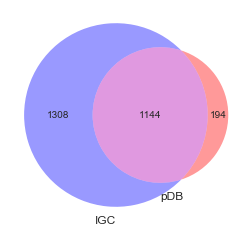

In [101]:
#Supplemental Figure 
venn = venn2([IGC_KOs,pDB_KOs], ['IGC','pDB'], set_colors = ('blue','red'))
plt.savefig('./pdfs/KO_IGCMP_Compare_venn.pdf')

In [103]:
#Create a list of the 24 samples
samples = ['LS3.23.14_2', 'LS5.22.16_3', 'LS12.7.14_3', 'LS4.3.12_3',
       'LS9.24.13_2', 'LS2.17.14_2', 'LS12.28.11_1', 'LS7.14.13_1',
       'LS9.24.13_1', 'LS12.28.11_2', 'LS5.22.16_2', 'LS7.14.13_2',
       'LS4.3.12_2', 'LS12.7.14_1', 'LS3.23.14_3', 'LS2.17.14_3', 'LS4.3.12_1',
       'LS7.14.13_3', 'LS2.17.14_1', 'LS12.28.11_3', 'LS3.23.14_1',
       'LS9.24.13_3', 'LS5.22.16_1', 'LS12.7.14_2']
#Display the number of samples present
len(samples)

24

In [104]:
MG = MG.merge(MG_ann, left_on = 'subjectID', right_on = 'Entry', how = 'left')
df = df.merge(protein_meta, left_on = 'subjectID', right_on = 'Entry', how = 'left')

In [105]:
#Split up dataframe by metadata for MG if you want to add GO categories...
s = MG['Cross-reference (KO)'].str.split(';').apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1) # to line up with df's index
s.name = 'Parsed_Categories'
GO = MG.join(s)
GO['Parsed_Categories'] = GO['Parsed_Categories'].str.strip()

#Group the data by GO terms
dfcategories2 = GO[samples].groupby([GO['Parsed_Categories']]).agg(['sum'])
dfcategories2.columns = dfcategories2.columns.droplevel(1)

#Find the number of genes contributing to the category
dfcategories2_count = GO[samples].groupby([GO['Parsed_Categories']]).count()

In [106]:
#Split up dataframe by protein metadata for pDB if you want to add GO categories...
s = df['Cross-reference (KO)'].str.split(';').apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1) # to line up with df's index
s.name = 'Parsed_Categories'
GO = df.join(s)
GO['Parsed_Categories'] = GO['Parsed_Categories'].str.strip()

#Group the data by GO terms
dfcategories = GO[samples].groupby([GO['Parsed_Categories']]).agg(['sum'])
dfcategories.columns = dfcategories.columns.droplevel(1)

#Find the number of genes contributing to the category
dfcategories_count = GO[samples].groupby([GO['Parsed_Categories']]).count()

In [107]:
#First make a list of the dates you want to average and get the standard deviation for
dates = ['LS12.28.11','LS4.3.12','LS7.14.13','LS9.24.13','LS2.17.14','LS3.23.14','LS12.7.14','LS5.22.16']

In [108]:
#Find the average and standard deviation of each of the samples
for i in dates:
    avgstd(dfcategories,"%s" %(i), "%s_Std" %(i), "%s_1" % (i), "%s_2" % (i), "%s_3" % (i))

In [109]:
for i in dates:
    sumstd(dfcategories2,"%s" %(i), "%s_Std" %(i), "%s_1" % (i), "%s_2" % (i), "%s_3" % (i))

In [110]:
#Save dfcategories without the dropped 0s for later
MG_KO = dfcategories2

#Replace 0s with 1s for pseudocounts in the MG for max/min comparisons

dfcategories2.replace(0,np.nan,inplace=True)
dfcategories2 = dfcategories2.dropna()

In [111]:
#Calculate the standard deviation of each protein and gene
dfcategories["Std"] = dfcategories[dates].std(axis = 1)
dfcategories2["Std"] = dfcategories2[dates].std(axis = 1)

#Calculate the log(Std) for display purposes
dfcategories['logStd'] = np.log10(dfcategories['Std'])
dfcategories2['logStd'] = np.log10(dfcategories2['Std'])

#Find the maximum value
dfcategories['Max'] = dfcategories[dates].max(axis=1)
dfcategories2['Max'] = dfcategories2[dates].max(axis=1)

#Find the minimum value
dfcategories['Min'] = dfcategories[dates].min(axis=1)
dfcategories2['Min'] = dfcategories2[dates].min(axis=1)

#Determine the maxmimum/minimum for the dynamic range of each protein or gene
dfcategories["Max/Min"] = dfcategories['Max']/dfcategories['Min']
dfcategories2["Max/Min"] = dfcategories2['Max']/dfcategories2['Min']

#Calculate the log(Max/Min) for display purposes
dfcategories['logMax/Min'] = np.log10(dfcategories['Max/Min'])
dfcategories2['logMax/Min'] = np.log10(dfcategories2['Max/Min'])

#Determine the Max - Min
dfcategories["Max-Min"] = dfcategories['Max']-dfcategories['Min']
dfcategories2["Max-Min"] = dfcategories2['Max']-dfcategories2['Min']

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

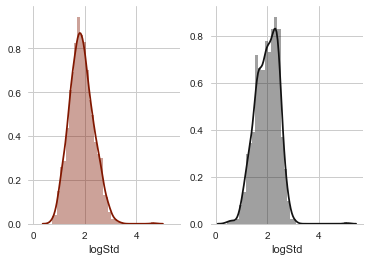

In [112]:
#Set style to have grids
sns.set_style("whitegrid")
# Set up the matplotlib figure
f, axes = plt.subplots(1,2, sharex=True)
sns.despine(left=True)
sns.distplot(dfcategories['logStd'], ax=axes[0],color ='#811700')
sns.distplot(dfcategories2['logStd'], ax=axes[1],color ='#131313')
plt.savefig('./pdfs/pDB_MG_STDDistributionKOs_sns_MGsums.pdf')

In [113]:
#Summary Statistics
scipy.stats.describe(dfcategories['logStd'])

DescribeResult(nobs=1337, minmax=(0.7222832887262638, 4.686822968986586), mean=1.8844557866060996, variance=0.21204260293908292, skewness=0.3871702712828622, kurtosis=0.6500615835038248)

In [114]:
#Summary Statistics
scipy.stats.describe(dfcategories2['logStd'])

DescribeResult(nobs=1255, minmax=(0.4249364644737066, 5.100375499307827), mean=1.98462473954833, variance=0.20042171748128518, skewness=-0.059298226520441685, kurtosis=1.3121324587476986)

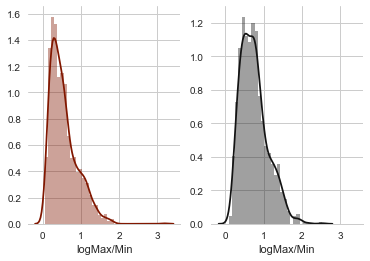

In [115]:
#Set style to have grids
sns.set_style("whitegrid")
# Set up the matplotlib figure
f, axes = plt.subplots(1,2, sharex=True)
sns.despine(left=True)
sns.distplot(dfcategories['logMax/Min'], ax=axes[0],color ='#811700')
sns.distplot(dfcategories2['logMax/Min'], ax=axes[1],color ='#131313')
plt.savefig('./pdfs/pDB_MG_MaxMinDistributionKOs_sns_MGsums.pdf')

In [116]:
#Summary Statistics
scipy.stats.describe(dfcategories['logMax/Min'])

DescribeResult(nobs=1337, minmax=(0.0521525356282006, 3.170401731075772), mean=0.5515168824006401, variance=0.12800678127563855, skewness=1.261657445468901, kurtosis=2.464866618535755)

In [117]:
#Summary Statistics
scipy.stats.describe(dfcategories2['logMax/Min'])

DescribeResult(nobs=1255, minmax=(0.09003809348965569, 2.536527972121719), mean=0.7506991089357681, variance=0.1275408042767193, skewness=0.866888138855917, kurtosis=0.7309319667857888)

In [118]:
#Only work with the averages of each of the dates
dfMP = dfcategories[dates]
dfMG = MG_KO[dates]
dfMP = dfMP.T
dfMG = dfMG.T

In [119]:
#Find overlapping GO categories in the metagenome and metaproteome
merge = dfcategories.merge(MG_KO, left_index = True, right_index = True)

In [120]:
MP_KOs = list(merge.index)

In [121]:
corrs = []
for i in MP_KOs:
    corr = dfMP['%s' % i].corr(dfMG['%s' % i], method = 'spearman')
    corrs.append(corr)

In [122]:
corrsdf = pd.DataFrame(
{'KO' : MP_KOs,
 'Spearman_Corr' : corrs})
corrsdf.index = corrsdf['KO']

In [123]:
dfcategories2_count['Genes_Counted'] = dfcategories2_count.sum(axis = 1)
dfcategories_count['Proteins_Counted'] = dfcategories_count.sum(axis = 1)
Spearman_table = pd.concat([dfcategories_count['Proteins_Counted'],dfcategories2_count['Genes_Counted'], corrsdf['Spearman_Corr']], axis = 1)

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  app.launch_new_instance()


In [124]:
#Drop the categories with not enough values to generate spearman correlations
df = Spearman_table.dropna()

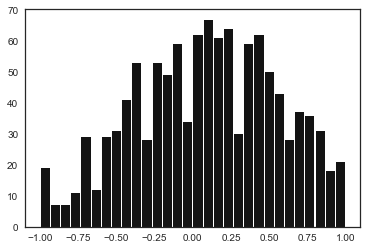

In [125]:
#Set style to have not have grids
sns.set_style("white")
plt.hist(df["Spearman_Corr"], color ='#131313', rwidth = 0.9, bins = 30)
plt.savefig('./pdfs/MPMG_KOs_SpearmanCorrelationDistributions_0forna_30bins_MGsums.pdf')

In [126]:
#Summary Statistics
scipy.stats.describe(df['Spearman_Corr'])

DescribeResult(nobs=1131, minmax=(-1.0, 1.0), mean=0.08960675339985687, variance=0.21659100489356825, skewness=-0.16074661318518332, kurtosis=-0.6469268221739721)

### Figure 4A & 4B - MG & MP Taxa Composition

In [28]:
#Read in data tables

#Metaproteome data table
df = pd.read_csv("./Duplicate_Peptide_Filter/pDB_CSVs/NormalizedDataAll_uniref50.csv", index_col = 'datarest$ProteinID')
df_IGC = pd.read_csv("./Duplicate_Peptide_Filter/IGC_CSVs/NormalizedDataAll.txt", index_col='datarest$ProteinID', sep='\t')

#Metagenome data table
MG = pd.read_csv("../Shotgun/Salmon_CPMs_Uniprot_Alignment.csv")

#Remove the genes with duplicate queryIDs
MG = MG.drop_duplicates(subset = 'queryID', keep = 'first')

#Read in metadata
meta = pd.read_csv('LS_Metadata.txt', sep = '\t', index_col = 'id')
protein_meta_IGC = pd.read_csv('./IGC_Approach/Protein_Metadata(wHuman).csv', index_col = 'datarest$ProteinID')
protein_meta = pd.read_csv('./Duplicate_Peptide_Filter/pDB_UniProtKB.txt', sep = '\t')
protein_taxa = pd.read_csv('../Shotgun/Taxa_annotations_expanded.csv')
MG_ann = pd.read_csv('../Shotgun/MG_UniprotKB_Annotations.txt', sep = '\t')

#First make a list of the dates you want to average and get the standard deviation for
dates = ['LS12.28.11','LS4.3.12','LS7.14.13','LS9.24.13','LS2.17.14','LS3.23.14','LS12.7.14','LS5.22.16']

#Generate averages and standard deviations for the technical replicates
for i in dates:
    avgstd(df,"%s" %(i), "%s_Std" %(i), "%s_1" % (i), "%s_2" % (i), "%s_3" % (i))
    
for i in dates:
    sumstd(MG,"%s" %(i), "%s_Std" %(i), "%s_1" % (i), "%s_2" % (i), "%s_3" % (i))
    
#Annotate your proteins with the uniref50, uniprotKB equivalents & taxa aligned from the custom database
MG = MG.merge(MG_ann, left_on = 'queryID', right_on = 'Entry', how = 'left')
MG = MG.merge(protein_taxa, left_on = 'queryID', right_on = 'Ref_ID', how = 'left')

df = df.merge(MG_ann, left_index = True, right_on = 'Entry', how = 'left')
df = df.merge(protein_taxa, left_on = 'queryID', right_on = 'Ref_ID', how = 'left')

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
#Aggregate genera sums
dfcategories = df[dates].groupby([df['Genus']]).agg(['sum'])
dfcategories.columns = dfcategories.columns.droplevel(1)
dfcategories2 = MG[dates].groupby([MG['Genus']]).agg(['sum'])
dfcategories2.columns = dfcategories2.columns.droplevel(1)

In [30]:
dfcategories.drop(labels = " g__", axis = 0,inplace = True)
dfcategories2.drop(labels = " g__", axis = 0,inplace = True)

In [31]:
dfcategories.index = dfcategories.index.dropna().map(lambda x: x.lstrip(' g__'))

In [32]:
dfcategories2.index = dfcategories2.index.dropna().map(lambda x: x.lstrip(' g__'))

In [33]:
#Calculate the percent abundances of each genera
for i in dates:
    dfcategories[i] = dfcategories[i]/dfcategories[i].sum()
    dfcategories2[i] = dfcategories2[i]/dfcategories2[i].sum()

In [34]:
#Find the sum of percentage of genera
dfcategories['sum'] = dfcategories.sum(axis = 1)
dfcategories2['sum'] = dfcategories2.sum(axis = 1)

In [35]:
#Remove low abundance genera for visualization purposes
dfcategories = dfcategories[dfcategories['sum'] > 0.03]
dfcategories2 = dfcategories2[dfcategories2['sum'] > 0.03]

In [36]:
#Recalculate percent abundances according to new sums
for i in dates:
    dfcategories[i] = dfcategories[i]/dfcategories[i].sum()
    dfcategories2[i] = dfcategories2[i]/dfcategories2[i].sum()

In [37]:
#Transpose the plot to make it fit the code structure I'm following for the stacked bar chart

#Remove index name
del dfcategories.index.name
#Sort samples by time
order=['LS12.28.11','LS4.3.12','LS7.14.13','LS9.24.13','LS2.17.14','LS3.23.14','LS12.7.14', 'LS5.22.16']
#Transpose
dfcategories = dfcategories.transpose()
#Get the dates in the correct order
dfcategories = dfcategories.reindex(order)
#Get Phyla into an order which depends on the abundance of each phyla for easier interpretation
dfcategories = dfcategories[dfcategories.sum().sort_values(ascending = False).index]

In [58]:
#Perform Friedman test on each sample to determine if there are differences between samples in the metagenome
scipy.stats.friedmanchisquare(dfcategories.as_matrix()[1],dfcategories.as_matrix()[2],dfcategories.as_matrix()[3],
                             dfcategories.as_matrix()[4], dfcategories.as_matrix()[5],dfcategories.as_matrix()[6],
                             dfcategories.as_matrix()[7],dfcategories.as_matrix()[0])


/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


FriedmanchisquareResult(statistic=4.784946236559222, pvalue=0.6861880561904661)

In [46]:
#Randomize Colors for Display
vals = np.linspace(0,1,30)
np.random.shuffle(vals)
my_cmap = plt.cm.colors.ListedColormap(plt.cm.Dark2(vals))

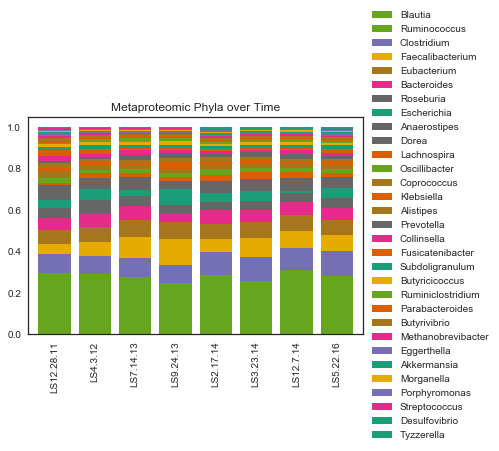

In [47]:
#Bar plot of pDB Genera Abundances
#my_cmap = plt.cm.colors.ListedColormap(plt.cm.Dark2(vals2))
#my_cmap = plt.cm.get_cmap('prism')
plot1 = dfcategories.plot(kind='bar',stacked=True, width = 0.8, colormap=my_cmap, title='Metaproteomic Phyla over Time')
plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plot1

#Save plot if desired
#plt.savefig('./pdfs/pDB_Genus_over_Time.pdf',bbox_inches="tight")

In [59]:
#Transpose the plot to make it fit the code structure I'm following for the stacked bar chart

#Remove index name
del dfcategories2.index.name
#Sort samples by time
order=['LS12.28.11','LS4.3.12','LS7.14.13','LS9.24.13','LS2.17.14','LS3.23.14','LS12.7.14', 'LS5.22.16']
#Transpose
dfcategories2 = dfcategories2.transpose()
#Get the dates in the correct order
dfcategories2 = dfcategories2.reindex(order)
#Get Phyla into an order which depends on the abundance of each phyla for easier interpretation
dfcategories2 = dfcategories2[dfcategories2.sum().sort_values(ascending = False).index]

In [60]:
#Perform Friedman test on each sample to determine if there are differences between samples in the metagenome 
scipy.stats.friedmanchisquare(dfcategories2.as_matrix()[1],dfcategories2.as_matrix()[2],dfcategories2.as_matrix()[3],
                             dfcategories2.as_matrix()[4], dfcategories2.as_matrix()[5],dfcategories2.as_matrix()[6],
                             dfcategories2.as_matrix()[7],dfcategories2.as_matrix()[0])

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


FriedmanchisquareResult(statistic=30.141025641025635, pvalue=8.946682593374125e-05)

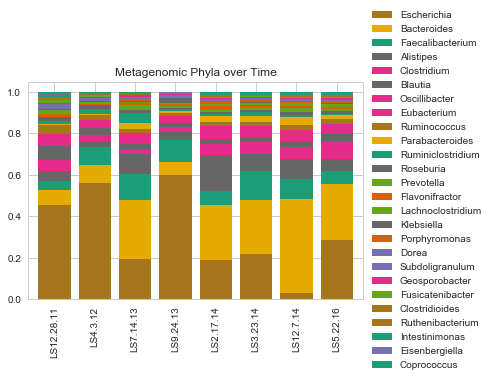

In [253]:
#Bar plot of pDB Genera Abundances
#my_cmap = plt.cm.colors.ListedColormap(plt.cm.Dark2(vals2))
#my_cmap = plt.cm.get_cmap('prism')
plot1 = dfcategories2.plot(kind='bar',stacked=True, width = 0.8, colormap=my_cmap, title='Metagenomic Phyla over Time')
plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plot1

#Save plot if desired
plt.savefig('./pdfs/MG_Genus_over_Time.pdf',bbox_inches="tight")

### MG & MP Significant LR Comparisons (Used in Figure 4,5, and supplemental)

In [48]:
#Read in data tables

#Metaproteome data table
df = pd.read_csv("./Duplicate_Peptide_Filter/pDB_CSVs/NormalizedDataAll_uniref50.csv")
df_IGC = pd.read_csv("./Duplicate_Peptide_Filter/IGC_CSVs/NormalizedDataAll.txt", index_col='datarest$ProteinID', sep='\t')

#Metagenome data table
MG = pd.read_csv("../Shotgun/Salmon_CPMs_Uniprot_Alignment.csv")
#Remove the genes with duplicate queryIDs
MG = MG.drop_duplicates(subset = 'queryID', keep = 'first')

In [49]:
#Save the protein UniprotIDs for later
UniprotpDB = pd.concat([df['datarest$ProteinID'],df['subjectID']], axis = 1).drop_duplicates()
df.index = df['datarest$ProteinID']

In [50]:
#Read in metadata
meta = pd.read_csv('LS_Metadata.txt', sep = '\t', index_col = 'id')
protein_meta_IGC = pd.read_csv('./IGC_Approach/Protein_Metadata(wHuman).csv', index_col = 'datarest$ProteinID')
protein_meta = pd.read_csv('./Duplicate_Peptide_Filter/pDB_UniProtKB.txt', sep = '\t')
protein_taxa = pd.read_csv('../Shotgun/Taxa_annotations_expanded.csv')
MG_ann = pd.read_csv('../Shotgun/MG_UniprotKB_Annotations.txt', sep = '\t')

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [51]:
#Annotate COG Categories
COG = pd.read_csv('../../Georgia State Collaboration/COG.description.csv')
COG.columns = ['COG', 'COG Protein Name']
COG_cats = pd.read_csv('../../Georgia State Collaboration/COG.funccat.csv')
COG_cats.columns = ['COG', 'eggNOG_Code']
Cat_key = pd.read_csv('../../Georgia State Collaboration/eggNOG_FunCats.csv')

In [52]:
samples = ['LS3.23.14_2', 'LS5.22.16_3', 'LS12.7.14_3', 'LS4.3.12_3',
       'LS9.24.13_2', 'LS2.17.14_2', 'LS12.28.11_1', 'LS7.14.13_1',
       'LS9.24.13_1', 'LS12.28.11_2', 'LS5.22.16_2', 'LS7.14.13_2',
       'LS4.3.12_2', 'LS12.7.14_1', 'LS3.23.14_3', 'LS2.17.14_3', 'LS4.3.12_1',
       'LS7.14.13_3', 'LS2.17.14_1', 'LS12.28.11_3', 'LS3.23.14_1',
       'LS9.24.13_3', 'LS5.22.16_1', 'LS12.7.14_2']
len(samples)

24

In [53]:
#Annotate your proteins with the uniref50, uniprotKB equivalents & taxa aligned from the custom database
MG = MG.merge(MG_ann, left_on = 'queryID', right_on = 'Entry', how = 'left')
MG = MG.merge(protein_taxa, left_on = 'queryID', right_on = 'Ref_ID', how = 'left')

df = df.merge(protein_taxa, left_index = True, right_on = 'Ref_ID', how = 'left')
df = df.merge(protein_meta, left_on = 'subjectID', right_on = 'Entry', how ='left')

In [54]:
#Reindex to the shared prodigal ID
MG.index = MG['queryID']

In [55]:
#Remove the human proteins for direct comparisons with microbes only
df_micro = df[df['queryID'].str.contains('k99_') == True]

In [56]:
df_micro.index = df_micro['queryID']

In [57]:
#First make a list of the dates you want to average and get the standard deviation for
dates = ['LS12.28.11','LS4.3.12','LS7.14.13','LS9.24.13','LS2.17.14','LS3.23.14','LS12.7.14','LS5.22.16']

In [58]:
#Find the averages of each dataset
for i in dates:
    avgstd(df_micro,"%s" %(i), "%s_Std" %(i), "%s_1" % (i), "%s_2" % (i), "%s_3" % (i))

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


for i in dates:
    avgstd(MG,"%s" %(i), "%s_Std" %(i), "%s_1" % (i), "%s_2" % (i), "%s_3" % (i))

In [59]:
for i in dates:
    sumstd(MG,"%s" %(i), "%s_Std" %(i), "%s_1" % (i), "%s_2" % (i), "%s_3" % (i))

In [60]:
#For Metaproteome:
df = df_micro[dates]

#For Metagenome
df2 = MG[dates]

In [61]:
#Generate a column for each of the three IBD activity markers

df.loc['Lysozyme'] = meta['Lysozyme C (MS)'].astype('float')
df.loc['Calprotectin'] = meta['Calprotectin (MS)'].astype('float')
df.loc['Lactoferrin'] = meta['Lactotransferrin (MS)'].astype('float')
#df.loc['CRP'] = meta['CRP'].astype('float')
df.loc['CRP'] = meta['CRP(Stool)'].astype('float')

#Generate a column for each of the three IBD activity markers

df2.loc['Lactoferrin'] = meta['Lactotransferrin (MS)'].astype('float')
df2.loc['Lysozyme'] = meta['Lysozyme C (MS)'].astype('float')
df2.loc['Calprotectin'] = meta['Calprotectin (MS)'].astype('float')
df2.loc['CRP'] = meta['CRP'].astype('float')

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/s

In [282]:
#Generate a list that is sorted by increasing values of the metadata of interest
#Cal_order = list(meta['Lysozyme C (MS)'].sort_values().index)
#Cal_order = list(meta['Calprotectin (MS)'].sort_values().index)
#Cal_order = list(meta['CRP'].sort_values().index)
Cal_order = list(meta['Lactoferrin'].sort_values().index)

In [283]:
#List the linear regression statistics for later
linregstats =['slope','intercept','rvalue','pvalue','stderr']

for i in linregstats:
    Cal_order.append(i)

In [284]:
#Generate two transposed versions of the dataframe for the linear regressions
df_m = df.T
df_n = df

#Generate two transposed versions of the dataframe for the linear regressions
df2_m = df2.T
df2_n = df2

In [285]:
#Reindex to align for linear regression
df_n.reindex(columns = Cal_order)
#Reindex to align for linear regression
df2_n.reindex(columns = Cal_order)

,LS5.22.16,LS3.23.14,LS12.7.14,LS4.3.12,LS9.24.13,LS2.17.14,LS12.28.11,LS7.14.13,slope,intercept,rvalue,pvalue,stderr
queryID,,,,,,,,,,,,,
k99_3_1,0.000000,2.189660,0.000000,0.000000,1.205970,5.241770,9.658580,0.000000,NaN,NaN,NaN,NaN,NaN
k99_7_1,7.375620,44.765210,29.251630,35.111480,25.413160,28.956810,11.644440,52.459120,NaN,NaN,NaN,NaN,NaN
k99_25_1,0.000000,1.785470,0.000000,0.000000,1.105600,4.042130,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
k99_25_2,0.000000,0.000000,0.735563,0.000000,0.000000,3.626260,1.113890,0.880500,NaN,NaN,NaN,NaN,NaN
k99_29_1,40.436880,104.291700,47.144070,16.749060,51.331200,163.564200,82.159700,100.707500,NaN,NaN,NaN,NaN,NaN
k99_29_2,36.916550,48.214400,64.723030,20.873630,47.802100,115.012200,25.633370,75.909900,NaN,NaN,NaN,NaN,NaN
k99_31_1,0.000000,0.000000,0.000000,0.000000,2.227570,4.506430,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
k99_33_1,0.000000,3.846571,1.721100,0.738950,0.000000,1.422571,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
k99_33_2,1.077400,2.481194,2.607724,0.000000,0.938619,0.827775,2.397710,0.000000,NaN,NaN,NaN,NaN,NaN


In [286]:
slope = []
intercept = []
rvalue = []
pvalue = []
stderr = []
for i in df_m:
    a = df_n.loc[i]
    b = df_n.loc[#'CRP'
            #'Calprotectin'
            #'Lysozyme'
            'Lactoferrin'
        ]
    linres = linregress(a[dates],b[dates])
    #linres = linregress(df_n.loc[i], df_n.loc[#'CRP'
            #'Calprotectin'
            #'Lysozyme'
            #'Lactoferrin'
                                             #])
    slope.append(linres.slope)
    intercept.append(linres.intercept)
    rvalue.append(linres.rvalue)
    pvalue.append(linres.pvalue)
    stderr.append(linres.stderr)
df_n['slope'] = slope
df_n['intercept'] = intercept
df_n['rvalue'] = rvalue
df_n['pvalue'] = pvalue
df_n['stderr'] = stderr
df_n

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,LS12.28.11,LS4.3.12,LS7.14.13,LS9.24.13,LS2.17.14,LS3.23.14,LS12.7.14,LS5.22.16,slope,intercept,rvalue,pvalue,stderr
queryID,,,,,,,,,,,,,
k99_1000046_1,137.834791,221.047163,120.275521,158.054066,81.217977,60.186253,73.967680,111.764665,0.000057,114.882203,0.000042,9.999217e-01,0.554454
k99_1000192_1,110.427409,115.927840,133.751317,66.684417,145.425579,134.723026,101.460375,130.849396,0.713375,31.134412,0.251475,5.479868e-01,1.120888
k99_100028_3,168.940314,115.623387,69.936235,172.694078,110.145594,119.321443,86.733568,118.902113,0.746547,25.089125,0.373875,3.615714e-01,0.756065
k99_100044_2,83.376280,75.584058,163.042306,79.668770,85.960781,84.939164,160.561600,92.413213,-0.724219,189.623613,-0.371264,3.652028e-01,0.739447
k99_100044_3,275.244328,105.264589,58.016207,163.342699,180.354974,82.985652,89.167111,138.191467,0.796857,6.061640,0.781466,2.200192e-02,0.259742
k99_1000497_2,129.301821,147.670285,112.577083,96.909731,119.266927,126.167795,145.514319,119.359240,-1.592211,313.272032,-0.374290,3.609953e-01,1.610431
k99_1000512_1,115.665134,58.583047,94.869180,193.560415,231.895774,106.914974,102.719917,104.582688,0.728038,23.084270,0.583045,1.292757e-01,0.414159
k99_1000590_1,44.115790,343.415287,10.782946,551.770328,28.097482,44.319065,14.122677,15.665993,-0.061681,123.002354,-0.176075,6.766188e-01,0.140780
k99_100074_1,108.318433,151.882825,133.959840,151.034682,79.765739,84.955992,120.375431,111.686874,-0.987829,231.203418,-0.377610,3.564064e-01,0.988911


In [287]:
slope = []
intercept = []
rvalue = []
pvalue = []
stderr = []
for i in df2_m:
    a = df2_n.loc[i]
    b = df2_n.loc[#'CRP'
                  'Lactoferrin'
            #'Calprotectin'
            #'Lysozyme'
        ]
    linres = linregress(a[dates],b[dates])
    #linres = linregress(df_n.loc[i], df_n.loc[#'CRP'
            #'Calprotectin'
            #'Lysozyme'
                                             #])
    slope.append(linres.slope)
    intercept.append(linres.intercept)
    rvalue.append(linres.rvalue)
    pvalue.append(linres.pvalue)
    stderr.append(linres.stderr)
df2_n['slope'] = slope
df2_n['intercept'] = intercept
df2_n['rvalue'] = rvalue
df2_n['pvalue'] = pvalue
df2_n['stderr'] = stderr
df2_n

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:95: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:97: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

,LS12.28.11,LS4.3.12,LS7.14.13,LS9.24.13,LS2.17.14,LS3.23.14,LS12.7.14,LS5.22.16,slope,intercept,rvalue,pvalue,stderr
queryID,,,,,,,,,,,,,
k99_3_1,9.658580,0.000000,0.000000,1.205970,5.241770,2.189660,0.000000,0.000000,14.690788,81.291243,0.719635,4.415955e-02,5.786786
k99_7_1,11.644440,35.111480,52.459120,25.413160,28.956810,44.765210,29.251630,7.375620,-2.403555,185.486697,-0.512997,1.935617e-01,1.641907
k99_25_1,0.000000,0.000000,0.000000,1.105600,4.042130,1.785470,0.000000,0.000000,20.430301,97.183119,0.416344,3.048763e-01,18.214186
k99_25_2,1.113890,0.000000,0.880500,0.000000,3.626260,0.000000,0.735563,0.000000,38.773361,84.082572,0.671841,6.803014e-02,17.451408
k99_29_1,82.159700,16.749060,100.707500,51.331200,163.564200,104.291700,47.144070,40.436880,0.798740,54.346079,0.524972,1.815747e-01,0.528669
k99_29_2,25.633370,20.873630,75.909900,47.802100,115.012200,48.214400,64.723030,36.916550,0.680808,77.862844,0.293176,4.809811e-01,0.906368
k99_31_1,0.000000,0.000000,0.000000,2.227570,4.506430,0.000000,0.000000,0.000000,24.005581,94.682342,0.564132,1.452416e-01,14.343978
k99_33_1,0.000000,0.738950,0.000000,0.000000,1.422571,3.846571,1.721100,0.000000,-23.813127,137.896068,-0.453281,2.593377e-01,19.117433
k99_33_2,2.397710,0.000000,0.000000,0.938619,0.827775,2.481194,2.607724,1.077400,-9.201958,126.771553,-0.138949,7.428053e-01,26.774238


In [288]:
#Add Benjamini Hochberg corrected p-values
pvals = df_n['pvalue']
BH_stats = fdrcorrection(pvals, alpha = 0.2, method = 'indep')
adj_pval = BH_stats[1]
df_n['pvalue_adj'] = adj_pval

#MG
pvals = df2_n['pvalue']
BH_stats = fdrcorrection(pvals, alpha = 0.2, method = 'indep')
adj_pval = BH_stats[1]
df2_n['pvalue_adj'] = adj_pval

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [289]:
#df_n.to_csv('./pDB_Cal_LR.csv')
#df2_n.to_csv('./MG_Cal_LR.csv')
#df2_n.to_csv('./MG_CRP(Stool)_LR.csv')
#df_n.to_csv('./pDB_CRP(Stool)_LR.csv')
#df2_n.to_csv('./MG_Lys_LR.csv')
#df_n.to_csv('./pDB_Lys_LR.csv')
df2_n.to_csv('./MG_Lactoferrin_LR.csv')
df_n.to_csv('./pDB_Lactoferrin_LR.csv')

#### Fig. 4 - Overlapping correlations

In [119]:
df_n = pd.read_csv('./pDB_Lactoferrin_LR.csv', index_col = 'queryID')
df2_n = pd.read_csv('./MG_Lactoferrin_LR.csv', index_col = 'queryID')
#df_n = pd.read_csv('./pDB_Cal_LR.csv', index_col = 'queryID')
#df2_n = pd.read_csv('./MG_Cal_LR.csv', index_col = 'queryID')
#df2_n = pd.read_csv('./MG_CRP_LR.csv', index_col = 'queryID')
#df_n = pd.read_csv('./pDB_CRP_LR.csv', index_col = 'queryID')
#df2_n = pd.read_csv('./MG_Lys_LR.csv', index_col = 'queryID')
#df_n = pd.read_csv('./pDB_Lys_LR.csv', index_col = 'queryID')
#df2_n = pd.read_csv('./MG_CRP(Stool)_LR.csv', index_col = 'queryID')
#df_n = pd.read_csv('./pDB_CRP(Stool)_LR.csv', index_col = 'queryID')

In [120]:
#Find the overlapping proteins
merge = df_n.merge(df2_n, left_index = True, right_index = True)
merge = list(merge.index)

In [121]:
#Determine Significant Proteins
#df_sig = df_n[df_n['pvalue'] < 0.05]
df_sig = df_n[abs(df_n['rvalue']) > 0.7]

#Determine Significant Proteins
#df2_sig = df2_n[df2_n['pvalue'] < 0.05]
df2_sig = df2_n[abs(df2_n['rvalue']) > 0.7]

In [122]:
df2_sig_shared = df2_sig.loc[merge].dropna()
df_sig_shared = df_sig.loc[merge].dropna()

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  from ipykernel import kernelapp as app


In [123]:
df_sig_MP = df_sig
df_sig_MG = df2_sig

In [124]:
#Significant overall
MG_pos = df_sig_MG[df_sig_MG['rvalue'] > 0]
MG_neg = df_sig_MG[df_sig_MG['rvalue'] < 0]
MP_pos = df_sig_MP[df_sig_MP['rvalue'] > 0]
MP_neg = df_sig_MP[df_sig_MP['rvalue'] < 0]

#Significant shared
MG2_pos = df2_sig_shared[df2_sig_shared['rvalue'] > 0]
MG2_neg = df2_sig_shared[df2_sig_shared['rvalue'] < 0]
MP2_pos = df_sig_shared[df_sig_shared['rvalue'] > 0]
MP2_neg = df_sig_shared[df_sig_shared['rvalue'] < 0]

In [125]:
#Overall
MG_pos_set = set(MG_pos.index.str.strip())
MG_neg_set = set(MG_neg.index.str.strip())
MP_pos_set = set(MP_pos.index.str.strip())
MP_neg_set = set(MP_neg.index.str.strip())

#Shared
MG2_pos_set = set(MG2_pos.index.str.strip())
MG2_neg_set = set(MG2_neg.index.str.strip())
MP2_pos_set = set(MP2_pos.index.str.strip())
MP2_neg_set = set(MP2_neg.index.str.strip())

In [126]:
a = len(MG_pos_set)
a2 = len(MG2_pos_set)

In [127]:
b =len(MP_pos_set)
b2 =len(MP2_pos_set)

In [128]:
Pos = MG_pos_set & MP_pos_set
c = len(Pos)

Pos2 = MG2_pos_set & MP2_pos_set
c2 = len(Pos2)

In [129]:
d = len(MG_neg_set)
d2 = len(MG2_neg_set)

In [130]:
e = len(MP_neg_set)
e2 = len(MP2_neg_set)

In [131]:
Neg = MG_neg_set & MP_neg_set
f = len(Neg)

Neg2 = MG2_neg_set & MP2_neg_set
f2 = len(Neg2)

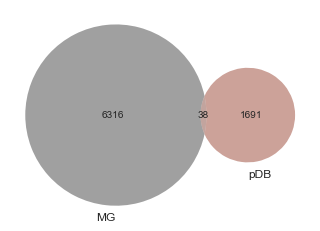

In [132]:
from matplotlib_venn import venn2
#Numbers came from adding the significant Positive and Negatively correlated from both data sets 
venn2([a + d - c - f,b + e - c - f, c + f], set_labels = ('MG', 'pDB'), set_colors = ('#131313','#811700'))
plt.savefig('./Duplicate_Peptide_Filter/LAC0.7_MGMP_Compare_venn_2.pdf')

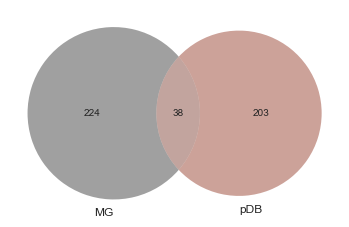

In [133]:
#Overlapping proteins only
venn2([a2 + d2 - c2 - f2,b2 + e2 - c2 - f2, c2 + f2], set_labels = ('MG', 'pDB'), set_colors = ('#131313','#811700'))
plt.savefig('./Duplicate_Peptide_Filter/LAC0.7_MGMP_Compare_venn_shared.pdf')

### Determine any taxonomic or functional biases in significant groups

In [139]:
#df_n = pd.read_csv('./pDB_Lactoferrin_LR.csv', index_col = 'queryID')
#df2_n = pd.read_csv('./MG_Lactoferrin_LR.csv', index_col = 'queryID')
#df_n = pd.read_csv('./pDB_Cal_LR.csv', index_col = 'queryID')
#df2_n = pd.read_csv('./MG_Cal_LR.csv', index_col = 'queryID')
#df2_n = pd.read_csv('./MG_CRP_LR.csv', index_col = 'queryID')
#df_n = pd.read_csv('./pDB_CRP_LR.csv', index_col = 'queryID')
df2_n = pd.read_csv('./MG_Lys_LR.csv', index_col = 'queryID')
df_n = pd.read_csv('./pDB_Lys_LR.csv', index_col = 'queryID')

In [140]:
df_n = df_n.merge(UniprotpDB, left_index = True, right_on = "datarest$ProteinID", how = 'left')

In [141]:
#Determine Significant Proteins
#df_sig = df_n[df_n['pvalue'] < 0.05]
df_sig = df_n[abs(df_n['rvalue']) > 0.7]

#Determine Significant Proteins
#df2_sig = df2_n[df2_n['pvalue'] < 0.05]
df2_sig = df2_n[abs(df2_n['rvalue']) > 0.7]

In [142]:
#Retrieve prodigal alignments to the uniref_50
Uniprot = pd.concat([MG['queryID'],MG['subjectID']], axis = 1).drop_duplicates()

#Add annotation information on the MG dataframe
df2_sig = df2_sig.merge(Uniprot, left_index = True, right_on = "queryID", how = 'left')
df2_sig = df2_sig.merge(protein_taxa, left_on = 'queryID', right_on = 'Ref_ID', how = 'left')
df2_sig = df2_sig.merge(MG_ann, left_on = 'subjectID', right_on = "Entry", how = 'left')

#Add annotation information to the protein dataframe
df_sig = df_sig.merge(protein_taxa, left_on = 'datarest$ProteinID', right_on = 'Ref_ID',how = 'left')
df_sig = df_sig.merge(protein_meta, left_on = 'subjectID', right_on = "Entry", how = 'left')

In [143]:
#df_sig.to_csv('./Duplicate_Peptide_Filter/Lactoferrin_Sig_Annotations.csv')

In [144]:
TaxaRatioCompare(df_sig,df2_sig,'Phylum','Lysozyme')

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

'Comparative ratios save under dataframe named Ratios, raw counts saved under datarame name Counts'

In [235]:
#Use this for eggNOG comparisons
eggRatioCompare(df_sig,df2_sig,'Lysozyme')

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

'Comparative ratios save under dataframe named Ratios, raw counts saved under dataframe named Counts'

In [236]:
#CalGenusCounts = Counts
#CalGenusRatios = Ratios
#CalEGGCounts = Counts
#CalEGGRatios = Ratios
#CRPGenusCounts = Counts
#CRPGenusRatios = Ratios
#CRPEGGCounts = Counts
#CRPEGGRatios = Ratios
#LysGenusCounts = Counts
#LysGenusRatios = Ratios
LysEGGCounts = Counts
LysEGGRatios = Ratios
#LacGenusCounts = Counts
#LacGenusRatios = Ratios
#LacEGGCounts = Counts
#LacEGGRatios = Ratios

In [248]:
GenusRatios = CalGenusRatios.merge(CRPGenusRatios, left_index = True, right_index = True, how = 'outer')
GenusRatios = GenusRatios.merge(LysGenusRatios, left_index = True, right_index = True, how = 'outer')                       

In [249]:
EGGRatios = CalEGGRatios.merge(CRPEGGRatios, left_index = True, right_index = True, how = 'outer')
EGGRatios = EGGRatios.merge(LysEGGRatios, left_index = True, right_index = True, how = 'outer')

In [250]:
GenusCounts = CalGenusCounts.merge(CRPGenusCounts, left_index = True, right_index = True, how = 'outer')
GenusCounts = GenusCounts.merge(LysGenusCounts, left_index = True, right_index = True, how = 'outer')                         

In [240]:
EGGCounts = CalEGGCounts.merge(CRPEGGCounts, left_index = True, right_index = True, how = 'outer')
EGGCounts = EGGCounts.merge(LysEGGCounts, left_index = True, right_index = True, how = 'outer')

In [242]:
GenusRatios = CalGenusRatios.merge(LacGenusRatios, left_index = True, right_index = True, how = 'outer')
#GenusRatios = GenusRatios.merge(LysGenusRatios, left_index = True, right_index = True, how = 'outer')  

In [243]:
GenusCounts = CalGenusCounts.merge(LacGenusCounts, left_index = True, right_index = True, how = 'outer')

In [244]:
EGGRatios = CalEGGRatios.merge(LacEGGRatios, left_index = True, right_index = True, how = 'outer')
EGGCounts = CalEGGCounts.merge(LacEGGCounts, left_index = True, right_index = True, how = 'outer')

In [241]:
EGGCounts.to_csv('./Duplicate_Peptide_Filter/LR Significant Correlations/EGGCounts_Combined_0.7.csv')
EGGRatios.to_csv('./Duplicate_Peptide_Filter/LR Significant Correlations/EGGRatios_Combined_0.7.csv')
GenusCounts.to_csv('./Duplicate_Peptide_Filter/LR Significant Correlations/GenusCounts_Combined_0.7.csv')
GenusRatios.to_csv('./Duplicate_Peptide_Filter/LR Significant Correlations/GenusRatios_Combined_0.7.csv')

In [245]:
EGGCounts.to_csv('./Duplicate_Peptide_Filter/LR Significant Correlations/EGGCounts_CalLac_0.7.csv')
EGGRatios.to_csv('./Duplicate_Peptide_Filter/LR Significant Correlations/EGGRatios_CalLac_0.7.csv')
GenusCounts.to_csv('./Duplicate_Peptide_Filter/LR Significant Correlations/GenusCounts_CalLac_0.7.csv')
GenusRatios.to_csv('./Duplicate_Peptide_Filter/LR Significant Correlations/GenusRatios_CalLac_0.7.csv')

In [318]:
#Counts.to_csv('./Duplicate_Peptide_Filter/LR Significant Correlations/eggCounts_CRPStool_New.csv')
#Ratios.to_csv('./Duplicate_Peptide_Filter/LR Significant Correlations/eggRatios_CRPStool_New.csv')
Counts.to_csv('./Duplicate_Peptide_Filter/LR Significant Correlations/eggCounts_Lactoferrin_New.csv')
Ratios.to_csv('./Duplicate_Peptide_Filter/LR Significant Correlations/eggRatios_Lactoferrin_New.csv')

In [246]:
Interest = [" g__Butyricicoccus",
" g__Faecalibacterium",
" g__Lachnospira",
" g__Roseburia",
" g__Eubacterium",
" g__Streptococcus",
" g__Butyrivibrio",
" g__Bacteroides",
" g__Blautia",
" g__Clostridium",
" g__Unknown",
" g__Subdoligranulum",
" g__Parabacteroides",
" g__Lachnoclostridium",
" g__Flavonifractor",
" g__Ruminococcus",
" g__Dorea",
" g__Eggerthella",
" g__Oscillibacter",
" g__Escherichia",
" g__Collinsella",
" g__Anaerostipes",
" g__Alistipes",
" g__Akkermansia"]

In [251]:
GenusCounts.loc[Interest].to_csv('./Duplicate_Peptide_Filter/LR Significant Correlations/GenusCounts_Combined_Interest_0.7.csv')
GenusRatios.loc[Interest].to_csv('./Duplicate_Peptide_Filter/LR Significant Correlations/GenusRatios_Combined_Interest_0.7.csv')

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  from ipykernel import kernelapp as app


In [247]:
GenusCounts.loc[Interest].to_csv('./Duplicate_Peptide_Filter/LR Significant Correlations/GenusCounts_CalLac_Interest_0.7.csv')
GenusRatios.loc[Interest].to_csv('./Duplicate_Peptide_Filter/LR Significant Correlations/GenusRatios_CalLac_Interest_0.7.csv')

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  from ipykernel import kernelapp as app


In [314]:
Counts.loc[Interest].to_csv('./Duplicate_Peptide_Filter/LR Significant Correlations/GenusCounts_Lac_Interest_New.csv')
Ratios.loc[Interest].to_csv('./Duplicate_Peptide_Filter/LR Significant Correlations/GenusRatios_Lac_Interest_New.csv')

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  from ipykernel import kernelapp as app


In [146]:
#For Phylum level assignments
Counts.to_csv('./Duplicate_Peptide_Filter/LR Significant Correlations/PhylumCounts_Lys_0.7.csv')
Ratios.to_csv('./Duplicate_Peptide_Filter/LR Significant Correlations/PhylumRatios_Lys_0.7.csv')

### Plotting Proteins of Interest

In [172]:
#Select proteins of interest

#From list of interesting...
#CRP_Chaps = pd.read_csv('./Duplicate_Peptide_Filter/pDB_Chaperones_SigInterest.csv')
CRP_Chaps = pd.read_csv('./Stool_CRP_Chaperones_list.csv')


#iron_prots = pd.read_csv('./Lactoferrin_IDs.txt', sep = "\t")
#Lys_prots = pd.read_csv('./Lysozyme_GramIDs.txt', sep = "\t")
#Cal_prots = pd.read_csv('./Cal_AA_Protein_IDs.txt', sep = "\t")
#Lys_prots = Lys_prots['Protein_ID']
#Cal_prots = Cal_prots['Protein_ID']
#iron_prots = iron_prots['ProteinID']
CRP_Chaps = list(CRP_Chaps['Ref_ID'])
CRP_Chaps

['k99_1038052_1',
 'k99_1139721_1',
 'k99_1187014_3',
 'k99_1203059_1',
 'k99_1256181_1',
 'k99_1270408_3',
 'k99_1292732_2',
 'k99_1465860_2',
 'k99_1529159_2',
 'k99_1554904_1',
 'k99_156539_2',
 'k99_1604618_2',
 'k99_1671308_3',
 'k99_1682608_2',
 'k99_1744777_1',
 'k99_1745955_1',
 'k99_1797275_1',
 'k99_1852408_1',
 'k99_1861092_1',
 'k99_1907375_3',
 'k99_1942925_1',
 'k99_213297_1',
 'k99_324578_1',
 'k99_3287_1',
 'k99_347792_1',
 'k99_375627_2',
 'k99_395379_6',
 'k99_4034_1',
 'k99_441166_2',
 'k99_441166_3',
 'k99_447969_1',
 'k99_459144_1',
 'k99_551798_1',
 'k99_612119_2',
 'k99_731579_1',
 'k99_795306_2',
 'k99_859147_1',
 'k99_901868_2',
 'k99_907674_1',
 'k99_984248_1']

#Determining proteins of interest
df2_n = pd.read_csv('./MG_CRP(Stool)_LR.csv')
df_n = pd.read_csv('./pDB_CRP(Stool)_LR.csv')

In [173]:
#Read in data tables

#Metaproteome data table
df = pd.read_csv("./Duplicate_Peptide_Filter/pDB_CSVs/NormalizedDataAll_uniref50.csv", index_col = 'datarest$ProteinID')
df_IGC = pd.read_csv("./Duplicate_Peptide_Filter/IGC_CSVs/NormalizedDataAll.txt", index_col='datarest$ProteinID', sep='\t')

#Metagenome data table
MG = pd.read_csv("../Shotgun/Salmon_CPMs_Uniprot_Alignment.csv")
#Remove the genes with duplicate queryIDs
MG = MG.drop_duplicates(subset = 'queryID', keep = 'first')

#Filter out human proteins to specifically look into the microbiome

df = df[df.index.str.contains('k99_') != False]

#Read in metadata
meta = pd.read_csv('LS_Metadata.txt', sep = '\t', index_col = 'id')
protein_meta_IGC = pd.read_csv('./IGC_Approach/Protein_Metadata(wHuman).csv', index_col = 'datarest$ProteinID')
protein_meta = pd.read_csv('./Duplicate_Peptide_Filter/pDB_UniProtKB.txt', sep = '\t')
protein_taxa = pd.read_csv('../Shotgun/Taxa_annotations_expanded.csv')
MG_ann = pd.read_csv('../Shotgun/MG_UniprotKB_Annotations.txt', sep = '\t')

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#Can use this for finding proteins of interest...
df_n = pd.read_csv('./pDB_CRP(Stool)_LR.csv', index_col = "queryID")
df_n = df_n.join(df['subjectID'])

df_n = df_n.merge(protein_taxa, left_index = True, right_on = 'Ref_ID', how = 'left')
df_n = df_n.merge(protein_meta, left_on = 'subjectID', right_on = 'Entry', how ='left')
df_n

In [174]:
samples = ['LS3.23.14_2', 'LS5.22.16_3', 'LS12.7.14_3', 'LS4.3.12_3',
       'LS9.24.13_2', 'LS2.17.14_2', 'LS12.28.11_1', 'LS7.14.13_1',
       'LS9.24.13_1', 'LS12.28.11_2', 'LS5.22.16_2', 'LS7.14.13_2',
       'LS4.3.12_2', 'LS12.7.14_1', 'LS3.23.14_3', 'LS2.17.14_3', 'LS4.3.12_1',
       'LS7.14.13_3', 'LS2.17.14_1', 'LS12.28.11_3', 'LS3.23.14_1',
       'LS9.24.13_3', 'LS5.22.16_1', 'LS12.7.14_2']
len(samples)

24

In [175]:
#Read in metadata
meta = pd.read_csv('LS_Metadata.txt', sep = '\t', index_col = 'id')
protein_meta_IGC = pd.read_csv('./IGC_Approach/Protein_Metadata(wHuman).csv', index_col = 'datarest$ProteinID')
protein_meta = pd.read_csv('./Duplicate_Peptide_Filter/pDB_UniProtKB.txt', sep = '\t')
protein_taxa = pd.read_csv('../Shotgun/Taxa_annotations_expanded.csv')
MG_ann = pd.read_csv('../Shotgun/MG_UniprotKB_Annotations.txt', sep = '\t')

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [176]:
#Annotate your proteins with the uniref50, uniprotKB equivalents & taxa aligned from the custom database
MG = MG.merge(MG_ann, left_on = 'queryID', right_on = 'Entry', how = 'left')
MG = MG.merge(protein_taxa, left_on = 'queryID', right_on = 'Ref_ID', how = 'left')

df = df.merge(protein_taxa, left_index = True, right_on = 'Ref_ID', how = 'left')
df = df.merge(protein_meta, left_on = 'subjectID', right_on = 'Entry', how ='left')

In [177]:
#If necessary, annotating proteins with COG protein names & removing duplicates

#ONLY if finding proteins of interest
#df = df_n

#CRP uses this
#Split up the entries with multiple eggNOG codes
s = df['Cross-reference (eggNOG)'].str.split(';').apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1) # to line up with df's index
s.name = 'Parsed_Categories'
GO = df.join(s)
GO['Parsed_Categories'] = GO['Parsed_Categories'].str.strip()

#If necessary, merge with eggNOG descriptions
df = GO.merge(COG_cats, left_on = 'Parsed_Categories', right_on = 'COG', how = 'left')
df = df.merge(Cat_key, left_on = 'eggNOG_Code', right_on = 'eggNOG Functional Assignment', how = 'left')
df = df.merge(COG, left_on = 'COG', right_on = 'COG', how = 'left')


#IF Necessary, add an additional step specifically for the proteins mapping to multiple COG which are of the same Description...
#labels = ['Ref_ID','Parsed_Categories']
#df['Ref_eggNOG'] = df['Ref_ID']+" "+df['Description']
#df['Ref_eggNOG']
#df = df.drop_duplicates(subset = 'Ref_eggNOG', keep = 'first')
#df

In [180]:
df.columns

Index(['Unnamed: 0_x', 'LS3.23.14_2', 'LS5.22.16_3', 'LS12.7.14_3',
       'LS4.3.12_3', 'LS9.24.13_2', 'LS2.17.14_2', 'LS12.28.11_1',
       'LS7.14.13_1', 'LS9.24.13_1', 'LS12.28.11_2', 'LS5.22.16_2',
       'LS7.14.13_2', 'LS4.3.12_2', 'LS12.7.14_1', 'LS3.23.14_3',
       'LS2.17.14_3', 'LS4.3.12_1', 'LS7.14.13_3', 'LS2.17.14_1',
       'LS12.28.11_3', 'LS3.23.14_1', 'LS9.24.13_3', 'LS5.22.16_1',
       'LS12.7.14_2', 'queryID', 'subjectID', 'percIdentity', 'alnLength',
       'mismatchCount', 'gapOpenCount', 'queryStart', 'queryEnd',
       'subjectStart', 'subjectEnd', 'eVal', 'bitScore', 'Unnamed: 0_y',
       'Ref_ID', 'Subject_ID', 'Num', 'Taxa', 'Kingdom', 'Phylum', 'Class',
       'Order', 'Famly', 'Genus', 'Species',
       'yourlist:M20180511F725F458AC8690F874DD868E4ED79B88FEB99DF', 'Entry',
       'Entry name', 'Status', 'Gene names', 'EC number', 'Function [CC]',
       'Pathway', 'Gene ontology (biological process)',
       'Gene ontology (cellular component)', 'Gene ont

In [181]:
df.index = df['Ref_ID']
df

,Unnamed: 0_x,LS3.23.14_2,LS5.22.16_3,LS12.7.14_3,LS4.3.12_3,LS9.24.13_2,LS2.17.14_2,LS12.28.11_1,LS7.14.13_1,LS9.24.13_1,...,Cross-reference (KO),Cross-reference (eggNOG),Cross-reference (KEGG),Parsed_Categories,COG,eggNOG_Code,eggNOG Functional Assignment,eggNOG Subgroup,Description,COG Protein Name
Ref_ID,,,,,,,,,,,,,,,,,,,,,
k99_1000046_1,110,61.067869,118.524388,68.681836,264.014067,171.733269,75.407012,110.085532,124.672957,144.374863,...,NaN,ENOG4105C5E;COG1086;,NaN,ENOG4105C5E,NaN,NaN,NaN,NaN,NaN,NaN
k99_1000046_1,110,61.067869,118.524388,68.681836,264.014067,171.733269,75.407012,110.085532,124.672957,144.374863,...,NaN,ENOG4105C5E;COG1086;,NaN,COG1086,COG1086,MG,NaN,NaN,NaN,Predicted nucleoside-diphosphate sugar epimerases
k99_1000046_1,110,61.067869,118.524388,68.681836,264.014067,171.733269,75.407012,110.085532,124.672957,144.374863,...,NaN,ENOG4105C5E;COG1086;,NaN,,NaN,NaN,NaN,NaN,NaN,NaN
k99_1000192_1,111,132.240162,128.182893,106.207889,113.250556,68.767526,146.534332,115.097499,140.505533,54.954461,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
k99_100028_3,112,119.321443,118.902113,86.733568,115.623387,172.694078,110.145594,168.940314,69.936235,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
k99_100044_2,114,77.675573,80.351490,181.768393,39.106655,97.539981,98.553995,61.926157,195.475603,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
k99_100044_3,115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,163.342699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
k99_1000497_2,116,131.543532,119.071840,241.041094,149.645728,82.554611,107.933536,155.855524,151.054945,111.326412,...,K02867;,NaN,lah:LA20533_01880;,NaN,NaN,NaN,NaN,NaN,NaN,NaN
k99_1000512_1,117,135.625310,117.325487,118.977517,63.209572,173.799545,179.143850,130.884341,109.407693,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#IF Finding new, such as CRP PTM proteins

sub = df[df['Description'] == 'Posttranslational modification, protein turnover, chaperones ']
sub = sub[sub['pvalue'] < 0.05]
sub = sub[sub['rvalue'] > 0]
sub.columns
sub['Ref_ID'].to_csv('./Stool_CRP_Chaperones_list.csv')

In [182]:
#Choose the subset you want to plot

#sub = df.loc[iron_prots]
sub = df.loc[CRP_Chaps]
#sub = df.loc[Lys_prots]
#sub = df.loc[Cal_prots]

In [183]:
#Choose either the COG protein names or the representative uniprot name derived from Uniref50

#Plot for CRP and Calprotectin uses this
sub['Gene_Genus'] = sub['Ref_ID'] +' ' + sub['COG Protein Name'] + ' ' + sub['Genus']

#Plots for Lysozyme and Lactoferrin use this 
#sub['Gene_Genus'] = sub['Ref_ID'] + ' ' + sub['Protein names'] + ' ' + sub['Genus']

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [184]:
sublist = list(sub['Gene_Genus'].dropna())
sub.index = sub['Gene_Genus']
sub = sub.loc[sublist].drop_duplicates()

In [185]:
dates = ['LS12.28.11',
 'LS4.3.12',
 'LS7.14.13',
 'LS9.24.13',
 'LS2.17.14',
 'LS3.23.14',
 'LS12.7.14',
 'LS5.22.16']
#sub = sub[dates]
sub = sub[samples]

In [186]:
sub = sub.T
sub['Date'] = list(sub.index.str[:-2])
subs = list(sub.columns)
subs.remove('Date')

In [187]:
d = {'Dates' : ['LS12.28.11','LS4.3.12','LS7.14.13','LS9.24.13','LS2.17.14','LS3.23.14','LS12.7.14', 'LS5.22.16'],
    'Time' : ["0","1","2","3","4","5","6","7"]}
order = pd.DataFrame(data = d)

In [188]:
df2 = sub.reset_index().merge(order, left_on = 'Date', right_on = 'Dates', how = 'outer')

In [189]:
df2['index'] = df2['index'].str[-1]

In [190]:
df2.dropna(axis = 1, inplace = True)

In [191]:
ids = ['Date','Time','index']
df2_melt = pd.melt(df2, id_vars =ids, value_vars = subs)
df2_melt = df2_melt.dropna()

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [192]:
#Retrieve Biomarker values from metadata
order = ['LS12.28.11','LS4.3.12','LS7.14.13','LS9.24.13','LS2.17.14','LS3.23.14','LS12.7.14', 'LS5.22.16']
#CalMS =  meta['Calprotectin (MS)'].astype('float')
#CalMS =  meta['Lactotransferrin (MS)'].astype('float')
#CalMS =  meta['Lysozyme C (MS)'].astype('float')
CalMS =  meta['CRP(Stool)'].astype('float')
#CalMS =  meta['CRP'].astype('float')
CalMS = CalMS.reindex(order)
CalMS

id
LS12.28.11    375.627695
LS4.3.12       33.272682
LS7.14.13     254.990981
LS9.24.13     128.426201
LS2.17.14      64.391249
LS3.23.14      22.726902
LS12.7.14      56.622070
LS5.22.16      52.121960
Name: CRP(Stool), dtype: float64

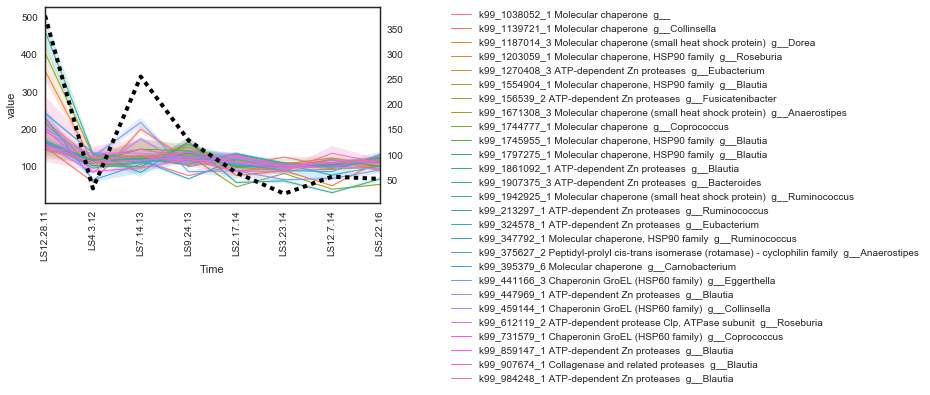

In [196]:
#Make plot
#Note - Some plots here do not show the full list of proteins, instead only the ones that have
#been visualized. Plots in main figures have other proteins of interest listed, which were significant,
#but did have missing values.

fig, ax = plt.subplots()
ax = sns.tsplot(time="Time", unit = "index", value = 'value', condition = "variable", data=df2_melt, linewidth = 1, linestyle = "-")#, linestyle = "--")
plt.legend(bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)
ax.set_xticklabels(dates)
ax2 = ax.twinx()
ax2 = sns.tsplot(CalMS, color = "black", linewidth=4, linestyle = ":")
fig.autofmt_xdate(rotation = 90, ha = 'center')

#Save in desired location
plt.savefig("./Duplicate_Peptide_Filter/pDB_CRPStool_Chaperones_ts_splitaxis.pdf",bbox_inches='tight')